###### This is a duplicate of `World_Happiness.ipynb` that uses an alternate hyperparameter tuning library, Optuna.

## Why We Chose This Dataset

We chose the **World Happiness Report dataset** because:

- ✅ **Recent data** – it includes the latest available happiness scores up to **2024**, making the analysis timely and relevant.
- 🌍 **Global coverage** – the dataset contains data from **~150+ countries**, allowing for broad cross-country comparisons.
- 📊 **Rich indicators** – in addition to the main **Life Ladder (happiness score)**, it provides key explanatory factors such as:
  - **Log GDP per capita** (economic prosperity)
  - **Social support** (community strength)
  - **Healthy life expectancy at birth** (health outcomes)
  - **Freedom to make life choices**
  - **Generosity**
  - **Perceptions of corruption**
  - **Positive and Negative affect** (emotional well-being)

Together, these indicators make the dataset ideal for **exploring global happiness trends** and **building predictive models** to understand what truly drives happiness worldwide.


In [1]:
# installing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna
import xgboost
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor



In [2]:
# read data
world_happiness_df = pd.read_csv("World-happiness-report-updated_2024.csv",  encoding="latin1")

In [3]:
world_happiness_df.shape

(2363, 11)

- There are 2,363 rows and 11 columns.


In [4]:
world_happiness_df.sample(5)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
1773,Saudi Arabia,2010,6.307,10.627,0.880,62.20,0.678,-0.034,NaN,0.645,0.297
129,Azerbaijan,2023,5.214,9.637,0.713,64.10,0.829,-0.160,0.627,0.509,0.221
1076,Kazakhstan,2018,6.008,10.148,0.937,64.60,0.840,-0.104,0.824,0.611,0.162
668,Finland,2011,7.354,10.754,0.938,69.82,0.936,0.095,0.320,0.709,0.205
1106,Kosovo,2013,6.126,9.046,0.721,NaN,0.568,0.114,0.935,0.650,0.203


Life Ladder → This is the actual happiness score (0–10).

Log GDP per capita → Economic factor, log-scaled for comparability.

Social support → Proportion of people with someone to rely on.

Healthy life expectancy at birth → Years expected in good health.

Freedom to make life choices → Satisfaction with freedom.

Generosity → Adjusted measure of charitable giving (can be negative).

Perceptions of corruption → Higher values = higher perceived corruption.

Positive affect / Negative affect → Average emotions reported.

Year → Lets you see trends over time.


In [5]:
# understanding data
world_happiness_df.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.4,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.7,0.531,0.234,0.776,0.614,0.268


In [6]:
# Statistical summary of the data
world_happiness_df.describe()

,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
count,2363.000000,2363.000000,2335.000000,2350.000000,2300.000000,2327.000000,2282.000000,2238.000000,2339.000000,2347.000000
mean,2014.763860,5.483566,9.399671,0.809369,63.401828,0.750282,0.000098,0.743971,0.651882,0.273151
std,5.059436,1.125522,1.152069,0.121212,6.842644,0.139357,0.161388,0.184865,0.106240,0.087131
min,2005.000000,1.281000,5.527000,0.228000,6.720000,0.228000,-0.340000,0.035000,0.179000,0.083000
25%,2011.000000,4.647000,8.506500,0.744000,59.195000,0.661000,-0.112000,0.687000,0.572000,0.209000
50%,2015.000000,5.449000,9.503000,0.834500,65.100000,0.771000,-0.022000,0.798500,0.663000,0.262000
75%,2019.000000,6.323500,10.392500,0.904000,68.552500,0.862000,0.093750,0.867750,0.737000,0.326000
max,2023.000000,8.019000,11.676000,0.987000,74.600000,0.985000,0.700000,0.983000,0.884000,0.705000


In [7]:
# Understanding data types and missing values
world_happiness_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2363 non-null   object 
 1   year                              2363 non-null   int64  
 2   Life Ladder                       2363 non-null   float64
 3   Log GDP per capita                2335 non-null   float64
 4   Social support                    2350 non-null   float64
 5   Healthy life expectancy at birth  2300 non-null   float64
 6   Freedom to make life choices      2327 non-null   float64
 7   Generosity                        2282 non-null   float64
 8   Perceptions of corruption         2238 non-null   float64
 9   Positive affect                   2339 non-null   float64
 10  Negative affect                   2347 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 203.2+ KB


- There are few missing data here.


In [8]:
world_happiness_df["Country name"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain',
       'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)',
       'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland',
       'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana',
       'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras',
       'Hong Kong S.A.R. of China', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy',
       'Ivory Coast', 'Jamaica', 'Japan', 

### Visualization


In [9]:
df = world_happiness_df.copy()

### Top and Bottom 10 Countries by Happiness (2024)

To get an overview of global happiness in the most recent year, we look at the **Life Ladder** scores:

- The **top 10 happiest countries** have the highest average Life Ladder scores.
- The **bottom 10 countries** show where people report the lowest perceived well-being.

These bar charts highlight the wide gap in happiness levels across the world and set the stage for exploring what factors (GDP, social support, life expectancy, etc.) might explain these differences.


C:\Users\Sohin\AppData\Local\Temp\ipykernel_53296\3735363238.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x='Life Ladder', y='Country name', palette="viridis")


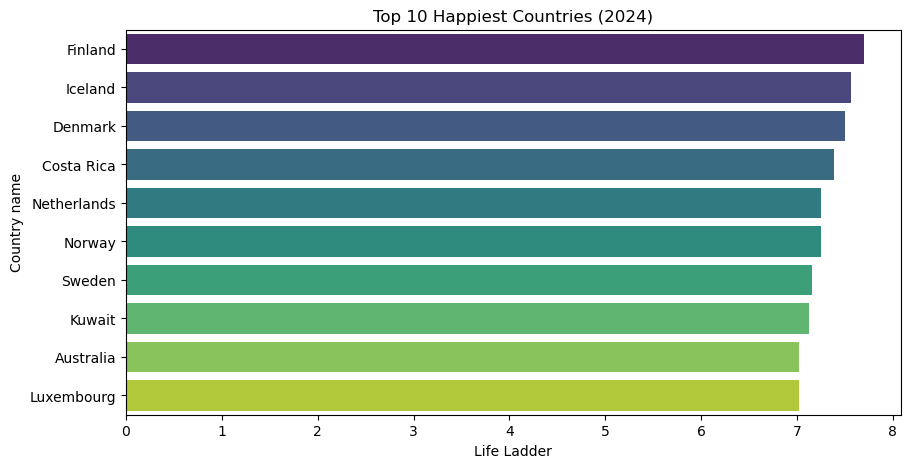

C:\Users\Sohin\AppData\Local\Temp\ipykernel_53296\3735363238.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom10, x='Life Ladder', y='Country name', palette="magma")


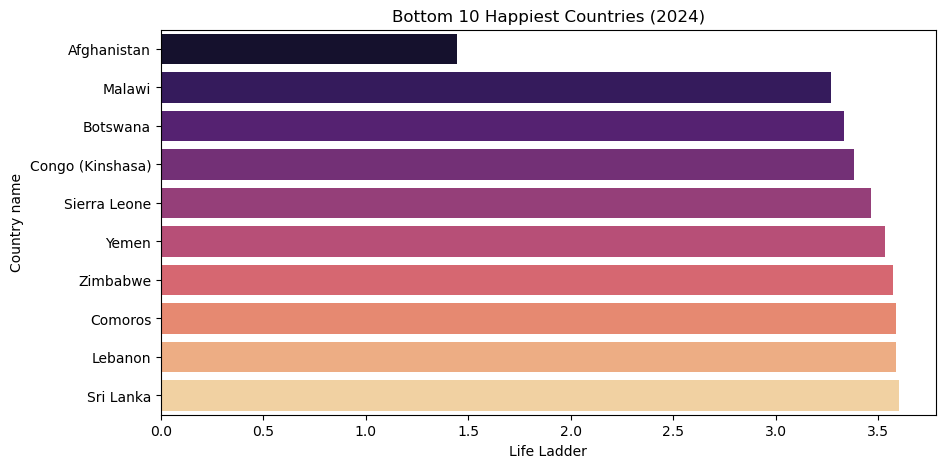

In [10]:
# Filter for latest year (2024 if available)
latest = df[df['year'] == df['year'].max()]

top10 = latest.nlargest(10, 'Life Ladder')
bottom10 = latest.nsmallest(10, 'Life Ladder')

plt.figure(figsize=(10,5))
sns.barplot(data=top10, x='Life Ladder', y='Country name', palette="viridis")
plt.title("Top 10 Happiest Countries (2024)")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=bottom10, x='Life Ladder', y='Country name', palette="magma")
plt.title("Bottom 10 Happiest Countries (2024)")
plt.show()

### Happiness Trends Over Time

This line plot shows how **Life Ladder (happiness score)** has changed from year to year for a selection of countries:

- **Finland** (one of the happiest countries worldwide)
- **India** (large developing country with improving but fluctuating scores)
- **United States** (a high-income country with mid-high happiness levels)
- **Afghanistan** (among the lowest happiness scores globally)

By comparing these diverse cases, we can see both **long-term stability in high-scoring countries** (e.g., Finland) and **sharp declines or volatility** in regions affected by conflict or economic challenges. This helps illustrate the global disparities in well-being over time.


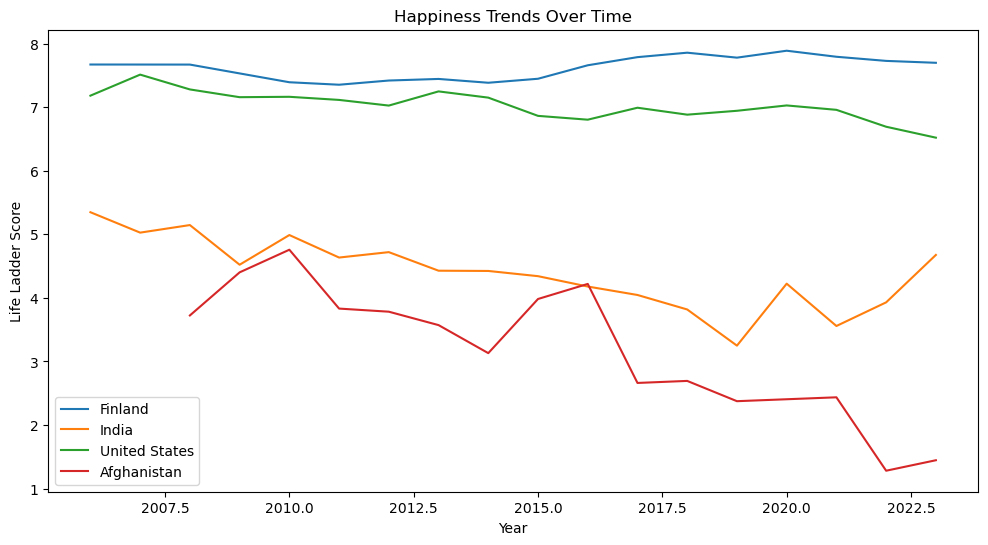

In [11]:
countries = ["Finland", "India", "United States", "Afghanistan"]
plt.figure(figsize=(12,6))
for c in countries:
    subset = df[df['Country name'] == c]
    plt.plot(subset['year'], subset['Life Ladder'], label=c)

plt.title("Happiness Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Life Ladder Score")
plt.legend()
plt.show()

### Key Factors Driving Happiness

To understand what drives happiness, we compare **Life Ladder scores** with three important factors in 2024:

- **Log GDP per capita** → captures the role of income and economic prosperity
- **Social support** → reflects the strength of community and relationships
- **Healthy life expectancy at birth** → measures health and longevity

Each scatter plot includes a regression line, making it easier to see overall trends.  
We observe that countries with **higher GDP, stronger social support, and longer life expectancy** tend to report higher happiness scores.  
This provides evidence that both **economic** and **social factors** play a critical role in well-being.


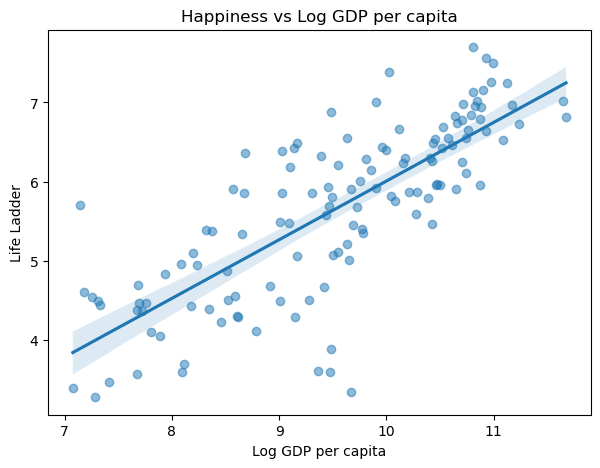

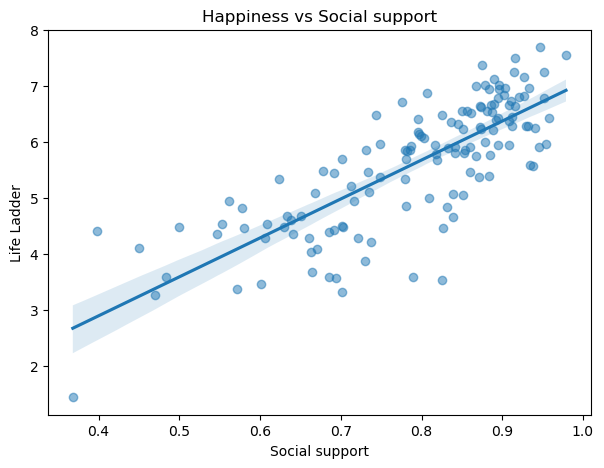

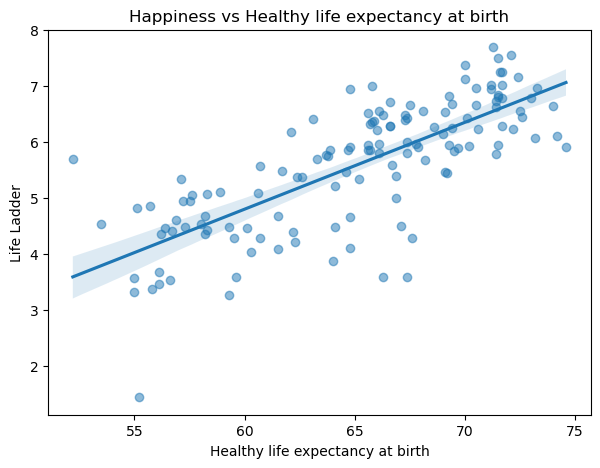

In [12]:
factors = ["Log GDP per capita", "Social support", "Healthy life expectancy at birth"]
for factor in factors:
    plt.figure(figsize=(7,5))
    sns.regplot(data=latest, x=factor, y="Life Ladder", scatter_kws={'alpha':0.5})
    plt.title(f"Happiness vs {factor}")
    plt.show()

### Correlation Between Happiness and Other Factors

This heatmap shows the correlations between **Life Ladder (happiness score)** and its key predictors:

- Strong **positive correlations**:
  - **GDP per capita**, **Social support**, **Life expectancy**, and **Freedom to make life choices** all align closely with higher happiness.
- Weak or mixed correlations:
  - **Generosity** and **Positive affect** show smaller positive links.
- **Negative correlation**:
  - **Perceptions of corruption** is strongly associated with lower happiness.
  - **Negative affect** also tends to reduce happiness.

Overall, the heatmap confirms that **economic prosperity, social ties, health, and freedom** are the most powerful drivers of happiness, while corruption and negative emotions erode well-being.


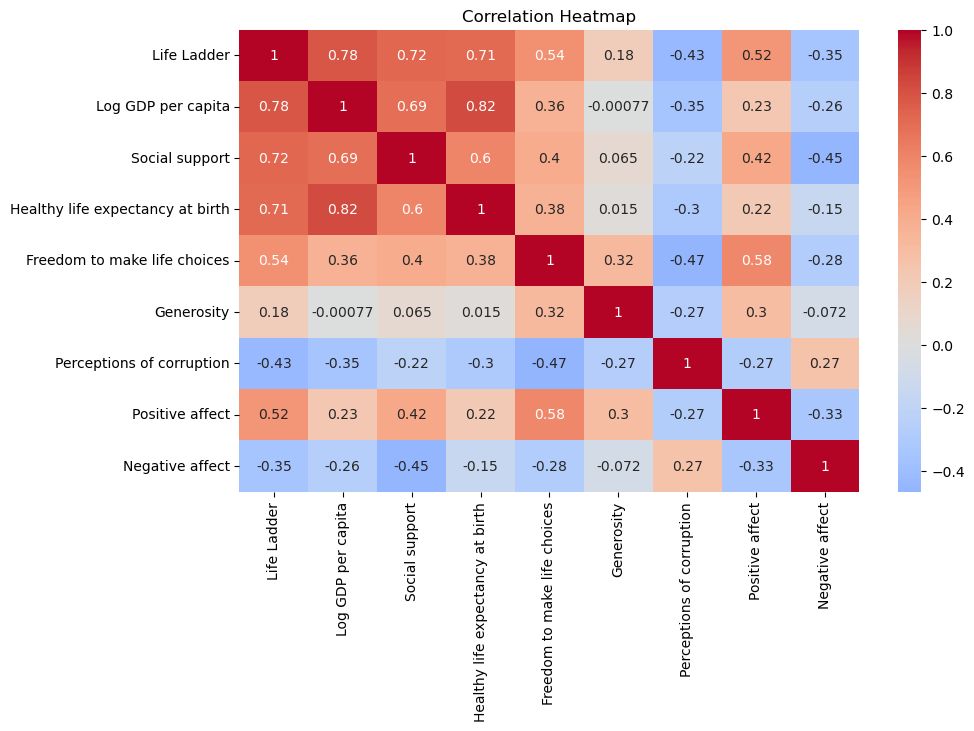

In [13]:
plt.figure(figsize=(10,6))
corr = df[["Life Ladder", "Log GDP per capita", "Social support",
           "Healthy life expectancy at birth", "Freedom to make life choices",
           "Generosity", "Perceptions of corruption",
           "Positive affect", "Negative affect"]].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

### Positive vs Negative Affect (2024)

This scatter plot compares countries based on **Positive affect** (frequency of positive emotions) and **Negative affect** (frequency of negative emotions) in 2024.

- The color and size of each point represent the **Life Ladder score** (overall happiness).
- Countries with **higher positive affect and lower negative affect** tend to report the highest happiness scores.
- Conversely, countries with **higher negative affect** cluster toward the lower end of the happiness scale.

This visualization highlights the strong emotional dimension of well-being, showing that happiness is not only about income or health but also about the balance of day-to-day emotions.


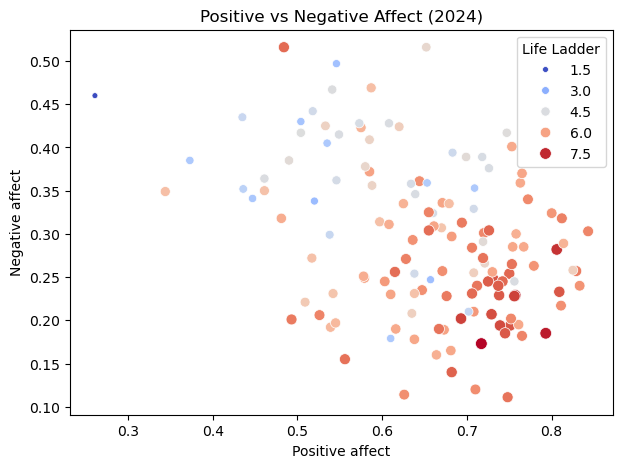

In [14]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=latest, x="Positive affect", y="Negative affect", hue="Life Ladder", size="Life Ladder", palette="coolwarm")
plt.title("Positive vs Negative Affect (2024)")
plt.show()

### Positive vs Negative Affect (2024)

This scatter plot compares countries based on **Positive affect** (frequency of positive emotions) and **Negative affect** (frequency of negative emotions) in 2024.

- The color and size of each point represent the **Life Ladder score** (overall happiness).
- Countries with **higher positive affect and lower negative affect** tend to report the highest happiness scores.
- Conversely, countries with **higher negative affect** cluster toward the lower end of the happiness scale.

This visualization highlights the strong emotional dimension of well-being, showing that happiness is not only about income or health but also about the balance of day-to-day emotions.


# Data Preprocessing and Modeling

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2363 non-null   object 
 1   year                              2363 non-null   int64  
 2   Life Ladder                       2363 non-null   float64
 3   Log GDP per capita                2335 non-null   float64
 4   Social support                    2350 non-null   float64
 5   Healthy life expectancy at birth  2300 non-null   float64
 6   Freedom to make life choices      2327 non-null   float64
 7   Generosity                        2282 non-null   float64
 8   Perceptions of corruption         2238 non-null   float64
 9   Positive affect                   2339 non-null   float64
 10  Negative affect                   2347 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 203.2+ KB


In [16]:
df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Index: 2097 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2097 non-null   object 
 1   year                              2097 non-null   int64  
 2   Life Ladder                       2097 non-null   float64
 3   Log GDP per capita                2097 non-null   float64
 4   Social support                    2097 non-null   float64
 5   Healthy life expectancy at birth  2097 non-null   float64
 6   Freedom to make life choices      2097 non-null   float64
 7   Generosity                        2097 non-null   float64
 8   Perceptions of corruption         2097 non-null   float64
 9   Positive affect                   2097 non-null   float64
 10  Negative affect                   2097 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 196.6+ KB


We have a pretty small amount of data: if we just dropped any line with a NaN value, we'd have fewer than 2100 lines! Even the full dataset only has 2363.

In [17]:
df.head(16)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.234,0.776,0.614,0.268
5,Afghanistan,2013,3.572,7.680,0.484,52.000,0.578,0.059,0.823,0.547,0.273
6,Afghanistan,2014,3.131,7.671,0.526,52.300,0.509,0.102,0.871,0.492,0.375
7,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.078,0.881,0.491,0.339
8,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.040,0.793,0.501,0.348
9,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.123,0.954,0.435,0.371


Demonstrating the structure of the problem. No NaNs in country name, thankfully. Presumably NaN appears where data is unavailable.

Likely the best we can do is infer those values from previous results.

In [18]:
df[df['Log GDP per capita'].isna() == True].head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
13,Afghanistan,2022,1.281,NaN,0.228,54.875,0.368,NaN,0.733,0.206,0.576
14,Afghanistan,2023,1.446,NaN,0.368,55.200,0.228,NaN,0.738,0.261,0.460
507,Cuba,2006,5.418,NaN,0.970,68.000,0.281,NaN,NaN,0.596,0.277
523,Cyprus,2023,6.071,NaN,0.803,73.200,0.730,NaN,0.840,0.682,0.297
1100,Kosovo,2007,5.104,NaN,0.848,NaN,0.381,NaN,0.894,0.614,0.237


In [19]:
df['year'].value_counts().sort_index(ascending=True)

year
2005     27
2006     89
2007    102
2008    110
2009    114
2010    124
2011    146
2012    141
2013    136
2014    144
2015    142
2016    141
2017    147
2018    141
2019    143
2020    116
2021    122
2022    140
2023    138
Name: count, dtype: int64

Simply forward- or backward-propagating or interpolating is going to be questionable. Not all information is available in every country in every year, so doing that naively may result in problems (e.g. Afghanistan's last year's GDP is NaN; backpropagating would fill it with info from Albania, which would be wrong). 

In [20]:
numeric_columns = df.select_dtypes(include='number').columns
df.groupby('Country name')[numeric_columns].apply(lambda group: group.infer_objects(copy=False).interpolate()).reset_index().drop('level_1', axis=1).head(16)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.234,0.776,0.614,0.268
5,Afghanistan,2013,3.572,7.680,0.484,52.000,0.578,0.059,0.823,0.547,0.273
6,Afghanistan,2014,3.131,7.671,0.526,52.300,0.509,0.102,0.871,0.492,0.375
7,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.078,0.881,0.491,0.339
8,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.040,0.793,0.501,0.348
9,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.123,0.954,0.435,0.371


Notice that Afghanistan's `Log GDP per capita` in 2022 and 2023 has been interpolated from 2021 without referencing the following row from Albania (so identical to forward propagation in this case). This basically gives our best estimate of what the missing data would be--it's not perfect, but we gain more from being able to preserve everything else in those columns.

In [21]:
data = df.groupby('Country name')[numeric_columns].apply(lambda group: group.infer_objects(copy=False).interpolate()).reset_index().drop('level_1', axis=1)

In [22]:
data.isna().sum()

Country name                         0
year                                 0
Life Ladder                          0
Log GDP per capita                  10
Social support                       4
Healthy life expectancy at birth    50
Freedom to make life choices         8
Generosity                          43
Perceptions of corruption           45
Positive affect                      8
Negative affect                      6
dtype: int64

There are still a few nulls that didn't get caught, but way fewer, so I'm fine dropping from here.

In [23]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2229 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2229 non-null   object 
 1   year                              2229 non-null   int64  
 2   Life Ladder                       2229 non-null   float64
 3   Log GDP per capita                2229 non-null   float64
 4   Social support                    2229 non-null   float64
 5   Healthy life expectancy at birth  2229 non-null   float64
 6   Freedom to make life choices      2229 non-null   float64
 7   Generosity                        2229 non-null   float64
 8   Perceptions of corruption         2229 non-null   float64
 9   Positive affect                   2229 non-null   float64
 10  Negative affect                   2229 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 209.0+ KB


The categorical `Country name` needs to be label encoded so that it can be handled numerically.

In [24]:
# data['country_label'] = data['Country name'].sort_values(ascending=True).astype('category').cat.codes
# data.sample(10)

data.drop('Country name', axis=1, inplace=True)

Since we're using time series data, we'll have the training set be years through 2019, and the test set be 2020 and onward (so roughly 1700 and 500 entries respectively, about 3.4 to 1 training to test ratio).

In [25]:
split_year = 2019
training = data[data['year'] <= split_year]
test = data[data['year'] > split_year]

training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1725 entries, 0 to 2358
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   year                              1725 non-null   int64  
 1   Life Ladder                       1725 non-null   float64
 2   Log GDP per capita                1725 non-null   float64
 3   Social support                    1725 non-null   float64
 4   Healthy life expectancy at birth  1725 non-null   float64
 5   Freedom to make life choices      1725 non-null   float64
 6   Generosity                        1725 non-null   float64
 7   Perceptions of corruption         1725 non-null   float64
 8   Positive affect                   1725 non-null   float64
 9   Negative affect                   1725 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 148.2 KB


In [26]:

features_train = training.drop(['Life Ladder'], axis=1)
features_test = test.drop(['Life Ladder'], axis=1)
target_train = training['Life Ladder']
target_test = test['Life Ladder']


Lastly, we need to ensure that our features are scaled; log GDP and life expectancy are both relatively large numbers compared to the other features and may have disproportionate impact on the model. We fit a StandardScaler on the just training features, because otherwise the scaler acts as a "hint" to the model during training (i.e. data leaks out of the test set), then we use it to transform both the features and target.

# Optuna and Modeling

Optuna is a library that specializes in tuning hyperparameters for machine learning models. This prevents us from having to code our own search or use something like scikit-learn's built-in functions, which are a little slow. For the purposes of this, we'll use XGBoost's random forest model.

Here's the sanity-check model, which is just sklearn's linear regression:

In [27]:
lr = LinearRegression()
lr.fit(features_train, target_train)
lr_pred = lr.predict(features_test)
lr_mae = mean_absolute_error(target_test, lr_pred)
lr_mae

0.3947212943765264

A good model should be able to beat this mean absolute error, no problem.

To use Optuna, we have to define functions called `objective` and `define_model`:

In [28]:
## Optuna with XGboostRF Regressor model 
def define_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200, step=10) #parameter name, lowest value, highest value, step size respectively
    max_depth = trial.suggest_int("max_depth", 2, 15, step=1)
    model = xgboost.XGBRFRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        random_state = 101010
    )
    return model

def objective(trial):
    model = define_model(trial)
    model.fit(features_train, target_train)
    target_pred = model.predict(features_test)
    score = mean_absolute_error(target_test, target_pred)
    trial.report(score, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return score


study = optuna.create_study()
study.optimize(objective, n_trials=40)

[I 2025-10-01 16:25:42,098] A new study created in memory with name: no-name-11fb9660-38e4-4b27-a4c9-920d4c43a4f0
[I 2025-10-01 16:25:42,152] Trial 0 finished with value: 0.3994021394706908 and parameters: {'n_estimators': 30, 'max_depth': 4}. Best is trial 0 with value: 0.3994021394706908.
[I 2025-10-01 16:25:42,216] Trial 1 finished with value: 0.43517611168301296 and parameters: {'n_estimators': 170, 'max_depth': 3}. Best is trial 0 with value: 0.3994021394706908.
[I 2025-10-01 16:25:42,323] Trial 2 finished with value: 0.3764037929867941 and parameters: {'n_estimators': 130, 'max_depth': 6}. Best is trial 2 with value: 0.3764037929867941.
[I 2025-10-01 16:25:42,355] Trial 3 finished with value: 0.3758579988441771 and parameters: {'n_estimators': 30, 'max_depth': 6}. Best is trial 3 with value: 0.3758579988441771.
[I 2025-10-01 16:25:42,516] Trial 4 finished with value: 0.34968870609525654 and parameters: {'n_estimators': 60, 'max_depth': 9}. Best is trial 4 with value: 0.3496887060

In [29]:
print('Best RF parameters: ', study.best_params)
print('At trial: ', study.best_trial.number)
print('Mean absolute error: ', study.best_value)
print('\nHyperparameter importances:')

importances = optuna.importance.get_param_importances(study=study) #evaluator is the default, FanovaImportanceEvaluator
importances



Best RF parameters:  {'n_estimators': 90, 'max_depth': 15}
At trial:  12
Mean absolute error:  0.3299729511018784

Hyperparameter importances:


{'max_depth': 0.9697119723888198, 'n_estimators': 0.030288027611180265}

So, for this data, we know the following about XGBoost's random forest: the best hyperparameters we could find were 100 trees with a max depth of 14; we were able to achieve a MAE of 0.319; and the max_depth parameter had a way bigger effect on the outcome of the forest than the n_estimators parameter did.

In [30]:
## Optuna with LGBM Regressor
def define_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200, step=10) #parameter name, lowest value, highest value, step size respectively
    max_depth = trial.suggest_int("max_depth", 2, 15, step=1)
    model1 = LGBMRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        random_state = 101010
    )
    return model1

def objective(trial):
    model1 = define_model(trial)
    model1.fit(features_train, target_train)
    target_pred = model1.predict(features_test)
    score = mean_absolute_error(target_test, target_pred)
    trial.report(score, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return score


study = optuna.create_study()
study.optimize(objective, n_trials=40)

[I 2025-10-01 16:26:09,230] A new study created in memory with name: no-name-4f41befb-2572-4b3e-bcdd-c070f0fcfae4
c:\Users\Sohin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Sohin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Sohin\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Sohin\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-10-01 16:26:09,353] Trial 0 finished with value: 0.3313109725161022 and parameters: {'n_estimators': 160, 'max_depth': 5}. Best is trial 0 with value: 0.3313109725161022.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-01 16:26:09,461] Trial 1 finished with value: 0.32200350189268034 and parameters: {'n_estimators': 170, 'max_depth': 7}. Best is trial 1 with value: 0.32200350189268034.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597


[I 2025-10-01 16:26:09,600] Trial 2 finished with value: 0.32263017912386405 and parameters: {'n_estimators': 170, 'max_depth': 9}. Best is trial 1 with value: 0.32200350189268034.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-01 16:26:09,710] Trial 3 finished with value: 0.3196962655875325 and parameters: {'n_estimators': 180, 'max_depth': 11}. Best is trial 3 with value: 0.3196962655875325.
[I 2025-10-01 16:26:09,778] Trial 4 finished with value: 0.32824143718783777 and parameters: {'n_estimators': 190, 'max_depth': 5}. Best is trial 3 with value: 0.3196962655875325.
[I 2025-10-01 16:26:09,834] Trial 5 pruned. 


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-01 16:26:09,850] Trial 6 pruned. 
[I 2025-10-01 16:26:09,873] Trial 7 pruned. 


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-01 16:26:09,950] Trial 8 pruned. 
[I 2025-10-01 16:26:10,008] Trial 9 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-01 16:26:10,039] Trial 10 pruned. 


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-01 16:26:10,171] Trial 11 finished with value: 0.3213602102425008 and parameters: {'n_estimators': 200, 'max_depth': 12}. Best is trial 3 with value: 0.3196962655875325.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-01 16:26:10,294] Trial 12 finished with value: 0.32122735726894297 and parameters: {'n_estimators': 200, 'max_depth': 13}. Best is trial 3 with value: 0.3196962655875325.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-01 16:26:10,390] Trial 13 finished with value: 0.32182389091817565 and parameters: {'n_estimators': 140, 'max_depth': 15}. Best is trial 3 with value: 0.3196962655875325.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the tr

[I 2025-10-01 16:26:10,517] Trial 14 finished with value: 0.3213602102425008 and parameters: {'n_estimators': 200, 'max_depth': 12}. Best is trial 3 with value: 0.3196962655875325.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-01 16:26:10,630] Trial 15 finished with value: 0.3187411441769178 and parameters: {'n_estimators': 160, 'max_depth': 14}. Best is trial 15 with value: 0.3187411441769178.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-01 16:26:10,729] Trial 16 finished with value: 0.31917546767402893 and parameters: {'n_estimators': 150, 'max_depth': 14}. Best is trial 15 with value: 0.3187411441769178.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-01 16:26:10,887] Trial 17 finished with value: 0.31917546767402893 and parameters: {'n_estimators': 150, 'max_depth': 14}. Best is trial 15 with value: 0.3187411441769178.
[I 2025-10-01 16:26:10,952] Trial 18 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training 

[I 2025-10-01 16:26:11,020] Trial 19 pruned. 


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-10-01 16:26:11,100] Trial 20 pruned. 
[I 2025-10-01 16:26:11,210] Trial 21 finished with value: 0.31917546767402893 and parameters: {'n_estimators': 150, 'max_depth': 14}. Best is trial 15 with value: 0.3187411441769178.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-01 16:26:11,312] Trial 22 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-01 16:26:11,398] Trial 23 pruned. 


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-01 16:26:11,493] Trial 24 finished with value: 0.32007709270549733 and parameters: {'n_estimators': 150, 'max_depth': 11}. Best is trial 15 with value: 0.3187411441769178.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-01 16:26:11,668] Trial 25 finished with value: 0.31678161894996637 and parameters: {'n_estimators': 180, 'max_depth': 14}. Best is trial 25 with value: 0.31678161894996637.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-01 16:26:11,903] Trial 26 finished with value: 0.3196962655875325 and parameters: {'n_estimators': 180, 'max_depth': 11}. Best is trial 25 with value: 0.31678161894996637.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-01 16:26:12,056] Trial 27 finished with value: 0.3175654465415472 and parameters: {'n_estimators': 170, 'max_depth': 14}. Best is trial 25 with value: 0.31678161894996637.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the tr

[I 2025-10-01 16:26:12,192] Trial 28 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-01 16:26:12,285] Trial 29 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-01 16:26:12,393] Trial 30 pruned. 


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-10-01 16:26:12,502] Trial 31 finished with value: 0.3187411441769178 and parameters: {'n_estimators': 160, 'max_depth': 14}. Best is trial 25 with value: 0.31678161894996637.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-01 16:26:12,630] Trial 32 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597


[I 2025-10-01 16:26:12,725] Trial 33 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 

[I 2025-10-01 16:26:12,867] Trial 34 pruned. 


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-01 16:26:13,037] Trial 35 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Foun

[I 2025-10-01 16:26:13,172] Trial 36 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-01 16:26:13,230] Trial 37 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the tr

[I 2025-10-01 16:26:13,335] Trial 38 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Foun

[I 2025-10-01 16:26:13,438] Trial 39 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [31]:
print('Best LGBM parameters: ', study.best_params)
print('At trial: ', study.best_trial.number)
print('Mean absolute error: ', study.best_value)
print('\nHyperparameter importances:')

importances = optuna.importance.get_param_importances(study=study) #evaluator is the default, FanovaImportanceEvaluator
importances

Best LGBM parameters:  {'n_estimators': 180, 'max_depth': 14}
At trial:  25
Mean absolute error:  0.31678161894996637

Hyperparameter importances:


{'max_depth': 0.9866690823972313, 'n_estimators': 0.013330917602768685}

So, for this data, we know the following about Light GBM: the best hyperparameters we could find with 200 estimators and max depth of 14; we were able to achieve a MAE of 0.316; and the  n_estimators parameter had a way bigger effect on the outcome  than the max_depth parameter did.

In [32]:
## Optuna with Catboost Regressor
def define_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200, step=10) #parameter name, lowest value, highest value, step size respectively
    max_depth = trial.suggest_int("max_depth", 1, 15, step=1) 
    model2= CatBoostRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        random_state = 101010
    )
    return model2

def objective(trial):
    model2 = define_model(trial)
    model2.fit(features_train, target_train)
    target_pred = model2.predict(features_test)
    score = mean_absolute_error(target_test, target_pred)
    trial.report(score, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return score


study = optuna.create_study()
study.optimize(objective, n_trials=40)

[I 2025-10-01 16:26:13,584] A new study created in memory with name: no-name-a7f3482b-75f4-4954-a638-0d30c9cf1549


Learning rate set to 0.268497
0:	learn: 0.9235130	total: 176ms	remaining: 19.1s
1:	learn: 0.7808614	total: 188ms	remaining: 10.2s
2:	learn: 0.6716396	total: 201ms	remaining: 7.17s
3:	learn: 0.5884340	total: 215ms	remaining: 5.68s
4:	learn: 0.5256085	total: 228ms	remaining: 4.79s
5:	learn: 0.4865453	total: 241ms	remaining: 4.17s
6:	learn: 0.4561736	total: 254ms	remaining: 3.74s
7:	learn: 0.4349445	total: 268ms	remaining: 3.42s
8:	learn: 0.4116666	total: 280ms	remaining: 3.15s
9:	learn: 0.3946029	total: 293ms	remaining: 2.93s
10:	learn: 0.3811597	total: 305ms	remaining: 2.75s
11:	learn: 0.3704461	total: 318ms	remaining: 2.59s
12:	learn: 0.3585302	total: 330ms	remaining: 2.46s
13:	learn: 0.3494040	total: 342ms	remaining: 2.34s
14:	learn: 0.3432093	total: 354ms	remaining: 2.24s
15:	learn: 0.3341669	total: 366ms	remaining: 2.15s
16:	learn: 0.3270498	total: 377ms	remaining: 2.06s
17:	learn: 0.3212576	total: 390ms	remaining: 1.99s
18:	learn: 0.3139072	total: 402ms	remaining: 1.92s
19:	learn: 

[I 2025-10-01 16:26:15,196] Trial 0 finished with value: 0.33948317730053024 and parameters: {'n_estimators': 110, 'max_depth': 10}. Best is trial 0 with value: 0.33948317730053024.
[I 2025-10-01 16:26:15,347] Trial 1 finished with value: 0.32707173754997326 and parameters: {'n_estimators': 120, 'max_depth': 5}. Best is trial 1 with value: 0.32707173754997326.


109:	learn: 0.0871026	total: 1.47s	remaining: 0us
Learning rate set to 0.25016
0:	learn: 0.9374771	total: 3.04ms	remaining: 361ms
1:	learn: 0.7974163	total: 3.89ms	remaining: 230ms
2:	learn: 0.7029532	total: 4.65ms	remaining: 182ms
3:	learn: 0.6255843	total: 5.43ms	remaining: 157ms
4:	learn: 0.5754655	total: 6.16ms	remaining: 142ms
5:	learn: 0.5403960	total: 7.02ms	remaining: 133ms
6:	learn: 0.5148247	total: 7.77ms	remaining: 126ms
7:	learn: 0.4978800	total: 8.58ms	remaining: 120ms
8:	learn: 0.4857787	total: 9.38ms	remaining: 116ms
9:	learn: 0.4768550	total: 10.1ms	remaining: 111ms
10:	learn: 0.4691530	total: 10.8ms	remaining: 107ms
11:	learn: 0.4635313	total: 11.5ms	remaining: 103ms
12:	learn: 0.4564417	total: 12.2ms	remaining: 100ms
13:	learn: 0.4534633	total: 12.9ms	remaining: 97.3ms
14:	learn: 0.4471805	total: 13.5ms	remaining: 94.8ms
15:	learn: 0.4416486	total: 14.3ms	remaining: 92.7ms
16:	learn: 0.4384455	total: 15ms	remaining: 90.9ms
17:	learn: 0.4353952	total: 15.8ms	remaining:

[I 2025-10-01 16:26:16,608] Trial 2 finished with value: 0.35977039188565757 and parameters: {'n_estimators': 50, 'max_depth': 11}. Best is trial 1 with value: 0.32707173754997326.


45:	learn: 0.1026366	total: 1.1s	remaining: 96ms
46:	learn: 0.1011286	total: 1.13s	remaining: 72.1ms
47:	learn: 0.0977445	total: 1.15s	remaining: 48ms
48:	learn: 0.0946677	total: 1.18s	remaining: 24ms
49:	learn: 0.0931005	total: 1.2s	remaining: 0us
Learning rate set to 0.234399
0:	learn: 0.9390540	total: 2.39ms	remaining: 308ms
1:	learn: 0.8086245	total: 4.42ms	remaining: 283ms
2:	learn: 0.7050431	total: 6.41ms	remaining: 272ms
3:	learn: 0.6272360	total: 8.22ms	remaining: 259ms
4:	learn: 0.5768336	total: 10.2ms	remaining: 254ms
5:	learn: 0.5381718	total: 11.9ms	remaining: 247ms
6:	learn: 0.5105938	total: 14ms	remaining: 247ms
7:	learn: 0.4901303	total: 15.8ms	remaining: 242ms
8:	learn: 0.4729334	total: 17.5ms	remaining: 235ms
9:	learn: 0.4597284	total: 19.2ms	remaining: 231ms
10:	learn: 0.4524075	total: 21ms	remaining: 227ms
11:	learn: 0.4450971	total: 22.9ms	remaining: 225ms
12:	learn: 0.4392385	total: 24.8ms	remaining: 223ms
13:	learn: 0.4332960	total: 26.7ms	remaining: 221ms
14:	lea

[I 2025-10-01 16:26:16,930] Trial 3 finished with value: 0.33953129462478665 and parameters: {'n_estimators': 130, 'max_depth': 7}. Best is trial 1 with value: 0.32707173754997326.


125:	learn: 0.1857605	total: 254ms	remaining: 8.05ms
126:	learn: 0.1843577	total: 256ms	remaining: 6.04ms
127:	learn: 0.1827389	total: 257ms	remaining: 4.02ms
128:	learn: 0.1819977	total: 259ms	remaining: 2.01ms
129:	learn: 0.1802073	total: 261ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.7919451	total: 635ms	remaining: 24.8s
1:	learn: 0.6187061	total: 991ms	remaining: 18.8s
2:	learn: 0.4934181	total: 1.33s	remaining: 16.5s
3:	learn: 0.4176895	total: 1.66s	remaining: 14.9s
4:	learn: 0.3691213	total: 2s	remaining: 14s
5:	learn: 0.3294935	total: 2.32s	remaining: 13.2s
6:	learn: 0.2951640	total: 2.64s	remaining: 12.4s
7:	learn: 0.2676994	total: 2.94s	remaining: 11.8s
8:	learn: 0.2464004	total: 3.24s	remaining: 11.2s
9:	learn: 0.2329459	total: 3.53s	remaining: 10.6s
10:	learn: 0.2192260	total: 3.82s	remaining: 10.1s
11:	learn: 0.2030692	total: 4.12s	remaining: 9.6s
12:	learn: 0.1911929	total: 4.4s	remaining: 9.14s
13:	learn: 0.1813623	total: 4.7s	remaining: 8.72s
14:	learn: 0.1674

[I 2025-10-01 16:26:28,640] Trial 4 finished with value: 0.3865974773626459 and parameters: {'n_estimators': 40, 'max_depth': 15}. Best is trial 1 with value: 0.32707173754997326.


39:	learn: 0.0497660	total: 11.6s	remaining: 0us
Learning rate set to 0.220694
0:	learn: 0.9734704	total: 68ms	remaining: 9.46s
1:	learn: 0.8443259	total: 139ms	remaining: 9.61s
2:	learn: 0.7385040	total: 208ms	remaining: 9.5s
3:	learn: 0.6546481	total: 276ms	remaining: 9.37s
4:	learn: 0.5849593	total: 343ms	remaining: 9.27s
5:	learn: 0.5339612	total: 413ms	remaining: 9.23s
6:	learn: 0.4900694	total: 487ms	remaining: 9.25s
7:	learn: 0.4545149	total: 558ms	remaining: 9.21s
8:	learn: 0.4240553	total: 626ms	remaining: 9.11s
9:	learn: 0.3994710	total: 696ms	remaining: 9.04s
10:	learn: 0.3784475	total: 765ms	remaining: 8.97s
11:	learn: 0.3599138	total: 834ms	remaining: 8.89s
12:	learn: 0.3444179	total: 909ms	remaining: 8.88s
13:	learn: 0.3298238	total: 977ms	remaining: 8.8s
14:	learn: 0.3177546	total: 1.05s	remaining: 8.72s
15:	learn: 0.3056375	total: 1.11s	remaining: 8.65s
16:	learn: 0.2955959	total: 1.19s	remaining: 8.64s
17:	learn: 0.2871044	total: 1.26s	remaining: 8.55s
18:	learn: 0.279

[I 2025-10-01 16:26:38,373] Trial 5 pruned. 
[I 2025-10-01 16:26:38,487] Trial 6 pruned. 


Learning rate set to 0.268497
0:	learn: 0.9554874	total: 772us	remaining: 84.2ms
1:	learn: 0.8178325	total: 1.31ms	remaining: 70.9ms
2:	learn: 0.7364597	total: 1.9ms	remaining: 67.8ms
3:	learn: 0.6722555	total: 2.35ms	remaining: 62.3ms
4:	learn: 0.6254309	total: 2.99ms	remaining: 62.7ms
5:	learn: 0.5935307	total: 3.51ms	remaining: 60.8ms
6:	learn: 0.5657221	total: 4.02ms	remaining: 59.2ms
7:	learn: 0.5457908	total: 4.53ms	remaining: 57.8ms
8:	learn: 0.5322859	total: 5.19ms	remaining: 58.2ms
9:	learn: 0.5235442	total: 5.81ms	remaining: 58.1ms
10:	learn: 0.5162644	total: 6.29ms	remaining: 56.6ms
11:	learn: 0.5099719	total: 6.92ms	remaining: 56.5ms
12:	learn: 0.5033944	total: 7.5ms	remaining: 56ms
13:	learn: 0.4997234	total: 8.04ms	remaining: 55.1ms
14:	learn: 0.4972357	total: 8.52ms	remaining: 53.9ms
15:	learn: 0.4945183	total: 8.98ms	remaining: 52.8ms
16:	learn: 0.4915701	total: 9.58ms	remaining: 52.4ms
17:	learn: 0.4890326	total: 10.1ms	remaining: 51.8ms
18:	learn: 0.4862840	total: 10.

[I 2025-10-01 16:26:40,676] Trial 7 finished with value: 0.3336887510534388 and parameters: {'n_estimators': 200, 'max_depth': 10}. Best is trial 1 with value: 0.32707173754997326.


188:	learn: 0.0818048	total: 1.97s	remaining: 115ms
189:	learn: 0.0813114	total: 1.98s	remaining: 104ms
190:	learn: 0.0802989	total: 1.99s	remaining: 93.9ms
191:	learn: 0.0800535	total: 2s	remaining: 83.5ms
192:	learn: 0.0797316	total: 2.01s	remaining: 73ms
193:	learn: 0.0794449	total: 2.02s	remaining: 62.6ms
194:	learn: 0.0789097	total: 2.04s	remaining: 52.2ms
195:	learn: 0.0784107	total: 2.04s	remaining: 41.8ms
196:	learn: 0.0773475	total: 2.06s	remaining: 31.3ms
197:	learn: 0.0770104	total: 2.07s	remaining: 20.9ms
198:	learn: 0.0764827	total: 2.08s	remaining: 10.4ms
199:	learn: 0.0760278	total: 2.09s	remaining: 0us
Learning rate set to 0.29013
0:	learn: 0.9165570	total: 20.4ms	remaining: 2.02s
1:	learn: 0.7529306	total: 41.4ms	remaining: 2.03s
2:	learn: 0.6405274	total: 62.6ms	remaining: 2.02s
3:	learn: 0.5593683	total: 83.5ms	remaining: 2s
4:	learn: 0.5069638	total: 104ms	remaining: 1.98s
5:	learn: 0.4661715	total: 125ms	remaining: 1.96s
6:	learn: 0.4312273	total: 145ms	remaining: 

[I 2025-10-01 16:26:42,706] Trial 8 pruned. 


91:	learn: 0.0724634	total: 1.8s	remaining: 156ms
92:	learn: 0.0712081	total: 1.82s	remaining: 137ms
93:	learn: 0.0699975	total: 1.84s	remaining: 117ms
94:	learn: 0.0693128	total: 1.85s	remaining: 97.6ms
95:	learn: 0.0679577	total: 1.87s	remaining: 78ms
96:	learn: 0.0667318	total: 1.89s	remaining: 58.5ms
97:	learn: 0.0656980	total: 1.91s	remaining: 39ms
98:	learn: 0.0647842	total: 1.93s	remaining: 19.5ms
99:	learn: 0.0636923	total: 1.95s	remaining: 0us
Learning rate set to 0.165141
0:	learn: 0.9991454	total: 5.33ms	remaining: 1.06s
1:	learn: 0.8880691	total: 25.4ms	remaining: 2.52s
2:	learn: 0.8025613	total: 30.2ms	remaining: 1.99s
3:	learn: 0.7304798	total: 34.8ms	remaining: 1.7s
4:	learn: 0.6672981	total: 40.3ms	remaining: 1.57s
5:	learn: 0.6167233	total: 45.2ms	remaining: 1.46s
6:	learn: 0.5749389	total: 49.8ms	remaining: 1.37s
7:	learn: 0.5387172	total: 54.7ms	remaining: 1.31s
8:	learn: 0.5108638	total: 59.6ms	remaining: 1.26s
9:	learn: 0.4909578	total: 64.4ms	remaining: 1.22s
10:	

[I 2025-10-01 16:26:43,787] Trial 9 finished with value: 0.3268012610946338 and parameters: {'n_estimators': 200, 'max_depth': 9}. Best is trial 9 with value: 0.3268012610946338.


Learning rate set to 0.165141
0:	learn: 1.0013466	total: 1.33ms	remaining: 265ms
1:	learn: 0.8975873	total: 2.28ms	remaining: 226ms
2:	learn: 0.8160374	total: 3.17ms	remaining: 208ms
3:	learn: 0.7389078	total: 3.96ms	remaining: 194ms
4:	learn: 0.6836903	total: 4.75ms	remaining: 185ms
5:	learn: 0.6380510	total: 5.56ms	remaining: 180ms
6:	learn: 0.6028356	total: 6.37ms	remaining: 176ms
7:	learn: 0.5729249	total: 7.39ms	remaining: 177ms
8:	learn: 0.5485052	total: 8.3ms	remaining: 176ms
9:	learn: 0.5306551	total: 9.12ms	remaining: 173ms
10:	learn: 0.5159466	total: 10.1ms	remaining: 174ms
11:	learn: 0.5038910	total: 11.1ms	remaining: 174ms
12:	learn: 0.4946367	total: 12ms	remaining: 172ms
13:	learn: 0.4862693	total: 12.8ms	remaining: 171ms
14:	learn: 0.4798368	total: 13.6ms	remaining: 168ms
15:	learn: 0.4745620	total: 14.4ms	remaining: 166ms
16:	learn: 0.4696727	total: 15.3ms	remaining: 164ms
17:	learn: 0.4633934	total: 16ms	remaining: 162ms
18:	learn: 0.4598679	total: 16.9ms	remaining: 161

[I 2025-10-01 16:26:44,046] Trial 10 finished with value: 0.3249068573406954 and parameters: {'n_estimators': 200, 'max_depth': 5}. Best is trial 10 with value: 0.3249068573406954.


191:	learn: 0.2510300	total: 186ms	remaining: 7.73ms
192:	learn: 0.2505955	total: 186ms	remaining: 6.76ms
193:	learn: 0.2502788	total: 187ms	remaining: 5.8ms
194:	learn: 0.2497604	total: 189ms	remaining: 4.84ms
195:	learn: 0.2488987	total: 190ms	remaining: 3.87ms
196:	learn: 0.2481412	total: 190ms	remaining: 2.9ms
197:	learn: 0.2469968	total: 191ms	remaining: 1.93ms
198:	learn: 0.2461433	total: 192ms	remaining: 964us
199:	learn: 0.2458982	total: 193ms	remaining: 0us
Learning rate set to 0.165141
0:	learn: 1.0013466	total: 1.4ms	remaining: 279ms
1:	learn: 0.8975873	total: 2.66ms	remaining: 263ms
2:	learn: 0.8160374	total: 3.49ms	remaining: 229ms
3:	learn: 0.7389078	total: 4.31ms	remaining: 211ms
4:	learn: 0.6836903	total: 5.17ms	remaining: 202ms
5:	learn: 0.6380510	total: 5.93ms	remaining: 192ms
6:	learn: 0.6028356	total: 6.71ms	remaining: 185ms
7:	learn: 0.5729249	total: 7.51ms	remaining: 180ms
8:	learn: 0.5485052	total: 8.28ms	remaining: 176ms
9:	learn: 0.5306551	total: 9.18ms	remaini

[I 2025-10-01 16:26:44,277] Trial 11 finished with value: 0.3249068573406954 and parameters: {'n_estimators': 200, 'max_depth': 5}. Best is trial 10 with value: 0.3249068573406954.


179:	learn: 0.2590952	total: 150ms	remaining: 16.7ms
180:	learn: 0.2586072	total: 151ms	remaining: 15.8ms
181:	learn: 0.2580058	total: 152ms	remaining: 15ms
182:	learn: 0.2573127	total: 153ms	remaining: 14.2ms
183:	learn: 0.2567408	total: 154ms	remaining: 13.4ms
184:	learn: 0.2560897	total: 155ms	remaining: 12.5ms
185:	learn: 0.2552084	total: 155ms	remaining: 11.7ms
186:	learn: 0.2546612	total: 156ms	remaining: 10.9ms
187:	learn: 0.2533269	total: 157ms	remaining: 10ms
188:	learn: 0.2528473	total: 158ms	remaining: 9.19ms
189:	learn: 0.2521559	total: 159ms	remaining: 8.35ms
190:	learn: 0.2516412	total: 159ms	remaining: 7.51ms
191:	learn: 0.2510300	total: 160ms	remaining: 6.67ms
192:	learn: 0.2505955	total: 161ms	remaining: 5.84ms
193:	learn: 0.2502788	total: 162ms	remaining: 5ms
194:	learn: 0.2497604	total: 162ms	remaining: 4.16ms
195:	learn: 0.2488987	total: 163ms	remaining: 3.33ms
196:	learn: 0.2481412	total: 164ms	remaining: 2.5ms
197:	learn: 0.2469968	total: 165ms	remaining: 1.67ms
1

[I 2025-10-01 16:26:44,459] Trial 12 pruned. 
[I 2025-10-01 16:26:44,569] Trial 13 pruned. 


Learning rate set to 0.188468
0:	learn: 1.0353696	total: 501us	remaining: 84.8ms
1:	learn: 0.9638195	total: 867us	remaining: 72.9ms
2:	learn: 0.9047812	total: 1.17ms	remaining: 64.9ms
3:	learn: 0.8464113	total: 1.47ms	remaining: 61.2ms
4:	learn: 0.8043422	total: 1.78ms	remaining: 58.9ms
5:	learn: 0.7684477	total: 2.14ms	remaining: 58.5ms
6:	learn: 0.7346854	total: 2.42ms	remaining: 56.5ms
7:	learn: 0.7065546	total: 2.68ms	remaining: 54.3ms
8:	learn: 0.6800537	total: 2.94ms	remaining: 52.7ms
9:	learn: 0.6581415	total: 3.21ms	remaining: 51.3ms
10:	learn: 0.6358670	total: 3.47ms	remaining: 50.2ms
11:	learn: 0.6212250	total: 3.76ms	remaining: 49.5ms
12:	learn: 0.6061357	total: 3.98ms	remaining: 48.1ms
13:	learn: 0.5959387	total: 4.25ms	remaining: 47.4ms
14:	learn: 0.5855614	total: 4.51ms	remaining: 46.6ms
15:	learn: 0.5751270	total: 4.78ms	remaining: 46ms
16:	learn: 0.5659519	total: 5.03ms	remaining: 45.3ms
17:	learn: 0.5588719	total: 5.31ms	remaining: 44.9ms
18:	learn: 0.5531196	total: 5.

[I 2025-10-01 16:26:44,857] Trial 14 finished with value: 0.3324781680777079 and parameters: {'n_estimators': 180, 'max_depth': 6}. Best is trial 10 with value: 0.3249068573406954.


65:	learn: 0.3375878	total: 81.5ms	remaining: 141ms
66:	learn: 0.3355376	total: 83.2ms	remaining: 140ms
67:	learn: 0.3340977	total: 84.5ms	remaining: 139ms
68:	learn: 0.3328537	total: 86ms	remaining: 138ms
69:	learn: 0.3308780	total: 87.2ms	remaining: 137ms
70:	learn: 0.3298090	total: 88.3ms	remaining: 136ms
71:	learn: 0.3274599	total: 89.5ms	remaining: 134ms
72:	learn: 0.3252478	total: 90.5ms	remaining: 133ms
73:	learn: 0.3244413	total: 91.6ms	remaining: 131ms
74:	learn: 0.3224587	total: 92.7ms	remaining: 130ms
75:	learn: 0.3202530	total: 93.9ms	remaining: 128ms
76:	learn: 0.3193765	total: 95.4ms	remaining: 128ms
77:	learn: 0.3173850	total: 96.6ms	remaining: 126ms
78:	learn: 0.3146248	total: 97.9ms	remaining: 125ms
79:	learn: 0.3134477	total: 99.6ms	remaining: 124ms
80:	learn: 0.3127230	total: 102ms	remaining: 124ms
81:	learn: 0.3117230	total: 104ms	remaining: 124ms
82:	learn: 0.3095949	total: 105ms	remaining: 123ms
83:	learn: 0.3070562	total: 107ms	remaining: 122ms
84:	learn: 0.30466

[I 2025-10-01 16:26:44,948] Trial 15 pruned. 


21:	learn: 0.4562615	total: 12.1ms	remaining: 26.4ms
22:	learn: 0.4546187	total: 12.6ms	remaining: 25.8ms
23:	learn: 0.4534284	total: 13.1ms	remaining: 25.1ms
24:	learn: 0.4517632	total: 13.6ms	remaining: 24.5ms
25:	learn: 0.4480695	total: 14.1ms	remaining: 23.9ms
26:	learn: 0.4458437	total: 14.6ms	remaining: 23.2ms
27:	learn: 0.4438889	total: 15ms	remaining: 22.5ms
28:	learn: 0.4412027	total: 15.5ms	remaining: 21.9ms
29:	learn: 0.4350470	total: 16.1ms	remaining: 21.4ms
30:	learn: 0.4323605	total: 16.5ms	remaining: 20.8ms
31:	learn: 0.4309802	total: 17ms	remaining: 20.2ms
32:	learn: 0.4284070	total: 17.5ms	remaining: 19.6ms
33:	learn: 0.4247750	total: 18ms	remaining: 19ms
34:	learn: 0.4225409	total: 18.5ms	remaining: 18.5ms
35:	learn: 0.4216860	total: 19ms	remaining: 17.9ms
36:	learn: 0.4187545	total: 19.4ms	remaining: 17.3ms
37:	learn: 0.4177006	total: 19.9ms	remaining: 16.8ms
38:	learn: 0.4159797	total: 20.4ms	remaining: 16.2ms
39:	learn: 0.4141727	total: 20.9ms	remaining: 15.7ms
40:

[I 2025-10-01 16:26:45,272] Trial 16 finished with value: 0.32711492811560966 and parameters: {'n_estimators': 150, 'max_depth': 7}. Best is trial 10 with value: 0.3249068573406954.


68:	learn: 0.2754028	total: 118ms	remaining: 138ms
69:	learn: 0.2732136	total: 120ms	remaining: 137ms
70:	learn: 0.2718491	total: 122ms	remaining: 135ms
71:	learn: 0.2705371	total: 124ms	remaining: 134ms
72:	learn: 0.2677697	total: 126ms	remaining: 132ms
73:	learn: 0.2669314	total: 128ms	remaining: 131ms
74:	learn: 0.2652582	total: 129ms	remaining: 129ms
75:	learn: 0.2631923	total: 131ms	remaining: 128ms
76:	learn: 0.2620097	total: 133ms	remaining: 126ms
77:	learn: 0.2611417	total: 135ms	remaining: 124ms
78:	learn: 0.2592918	total: 137ms	remaining: 123ms
79:	learn: 0.2585145	total: 139ms	remaining: 122ms
80:	learn: 0.2551016	total: 142ms	remaining: 121ms
81:	learn: 0.2539169	total: 144ms	remaining: 119ms
82:	learn: 0.2522281	total: 146ms	remaining: 118ms
83:	learn: 0.2516664	total: 148ms	remaining: 116ms
84:	learn: 0.2490819	total: 149ms	remaining: 114ms
85:	learn: 0.2483491	total: 151ms	remaining: 112ms
86:	learn: 0.2462968	total: 152ms	remaining: 110ms
87:	learn: 0.2444540	total: 154

[I 2025-10-01 16:26:45,328] Trial 17 pruned. 


0:	learn: 0.7705664	total: 1ms	remaining: 9.04ms
1:	learn: 0.6258227	total: 1.69ms	remaining: 6.76ms
2:	learn: 0.5439746	total: 2.26ms	remaining: 5.28ms
3:	learn: 0.5109764	total: 2.92ms	remaining: 4.38ms
4:	learn: 0.4931098	total: 3.49ms	remaining: 3.49ms
5:	learn: 0.4847456	total: 4.09ms	remaining: 2.73ms
6:	learn: 0.4782577	total: 4.63ms	remaining: 1.98ms
7:	learn: 0.4744883	total: 5.15ms	remaining: 1.29ms
8:	learn: 0.4678890	total: 5.94ms	remaining: 659us
9:	learn: 0.4616262	total: 6.87ms	remaining: 0us
Learning rate set to 0.19799
0:	learn: 0.9711662	total: 3.32ms	remaining: 527ms
1:	learn: 0.8483252	total: 6.02ms	remaining: 476ms
2:	learn: 0.7544147	total: 8.68ms	remaining: 454ms
3:	learn: 0.6781611	total: 11.6ms	remaining: 451ms
4:	learn: 0.6175739	total: 14.5ms	remaining: 449ms
5:	learn: 0.5691881	total: 17.1ms	remaining: 438ms
6:	learn: 0.5346205	total: 19.5ms	remaining: 426ms
7:	learn: 0.5074638	total: 22.5ms	remaining: 427ms
8:	learn: 0.4850628	total: 25ms	remaining: 420ms
9

[I 2025-10-01 16:26:45,865] Trial 18 finished with value: 0.3176245410574978 and parameters: {'n_estimators': 160, 'max_depth': 8}. Best is trial 18 with value: 0.3176245410574978.


114:	learn: 0.1807680	total: 331ms	remaining: 130ms
115:	learn: 0.1795864	total: 335ms	remaining: 127ms
116:	learn: 0.1778718	total: 337ms	remaining: 124ms
117:	learn: 0.1770454	total: 340ms	remaining: 121ms
118:	learn: 0.1757318	total: 343ms	remaining: 118ms
119:	learn: 0.1750950	total: 346ms	remaining: 115ms
120:	learn: 0.1740782	total: 349ms	remaining: 112ms
121:	learn: 0.1732730	total: 352ms	remaining: 109ms
122:	learn: 0.1727139	total: 354ms	remaining: 107ms
123:	learn: 0.1719041	total: 357ms	remaining: 104ms
124:	learn: 0.1714417	total: 360ms	remaining: 101ms
125:	learn: 0.1698183	total: 363ms	remaining: 98ms
126:	learn: 0.1684090	total: 366ms	remaining: 95.1ms
127:	learn: 0.1672179	total: 369ms	remaining: 92.2ms
128:	learn: 0.1667240	total: 371ms	remaining: 89.3ms
129:	learn: 0.1658838	total: 374ms	remaining: 86.4ms
130:	learn: 0.1645747	total: 377ms	remaining: 83.6ms
131:	learn: 0.1638974	total: 380ms	remaining: 80.7ms
132:	learn: 0.1627793	total: 383ms	remaining: 77.8ms
133:	l

[I 2025-10-01 16:26:46,356] Trial 19 finished with value: 0.32839120424504986 and parameters: {'n_estimators': 150, 'max_depth': 8}. Best is trial 18 with value: 0.3176245410574978.


146:	learn: 0.1412984	total: 418ms	remaining: 8.54ms
147:	learn: 0.1410128	total: 421ms	remaining: 5.69ms
148:	learn: 0.1407215	total: 424ms	remaining: 2.84ms
149:	learn: 0.1403878	total: 427ms	remaining: 0us
Learning rate set to 0.17991
0:	learn: 0.9854376	total: 4.1ms	remaining: 735ms
1:	learn: 0.8715402	total: 7.76ms	remaining: 691ms
2:	learn: 0.7823147	total: 10.5ms	remaining: 622ms
3:	learn: 0.7064430	total: 13.6ms	remaining: 600ms
4:	learn: 0.6460637	total: 16.5ms	remaining: 578ms
5:	learn: 0.5963772	total: 19ms	remaining: 551ms
6:	learn: 0.5592923	total: 21.8ms	remaining: 540ms
7:	learn: 0.5313805	total: 23ms	remaining: 496ms
8:	learn: 0.5090668	total: 25.6ms	remaining: 486ms
9:	learn: 0.4903475	total: 28.2ms	remaining: 479ms
10:	learn: 0.4744045	total: 31.5ms	remaining: 485ms
11:	learn: 0.4593921	total: 34.8ms	remaining: 487ms
12:	learn: 0.4475933	total: 38ms	remaining: 488ms
13:	learn: 0.4377571	total: 41.1ms	remaining: 488ms
14:	learn: 0.4290392	total: 44ms	remaining: 484ms
1

[I 2025-10-01 16:26:46,935] Trial 20 finished with value: 0.32692603720420244 and parameters: {'n_estimators': 180, 'max_depth': 8}. Best is trial 18 with value: 0.3176245410574978.


121:	learn: 0.1854116	total: 350ms	remaining: 166ms
122:	learn: 0.1836536	total: 353ms	remaining: 164ms
123:	learn: 0.1824810	total: 356ms	remaining: 161ms
124:	learn: 0.1814052	total: 358ms	remaining: 158ms
125:	learn: 0.1805252	total: 361ms	remaining: 155ms
126:	learn: 0.1796364	total: 364ms	remaining: 152ms
127:	learn: 0.1776215	total: 368ms	remaining: 149ms
128:	learn: 0.1771658	total: 370ms	remaining: 146ms
129:	learn: 0.1757577	total: 373ms	remaining: 143ms
130:	learn: 0.1742970	total: 375ms	remaining: 140ms
131:	learn: 0.1725541	total: 379ms	remaining: 138ms
132:	learn: 0.1710785	total: 381ms	remaining: 135ms
133:	learn: 0.1701880	total: 384ms	remaining: 132ms
134:	learn: 0.1683272	total: 387ms	remaining: 129ms
135:	learn: 0.1669370	total: 390ms	remaining: 126ms
136:	learn: 0.1659225	total: 393ms	remaining: 123ms
137:	learn: 0.1649898	total: 396ms	remaining: 120ms
138:	learn: 0.1641362	total: 399ms	remaining: 118ms
139:	learn: 0.1630026	total: 402ms	remaining: 115ms
140:	learn: 

[I 2025-10-01 16:26:47,249] Trial 21 finished with value: 0.32634537666818264 and parameters: {'n_estimators': 200, 'max_depth': 6}. Best is trial 18 with value: 0.3176245410574978.


145:	learn: 0.2435256	total: 186ms	remaining: 68.9ms
146:	learn: 0.2428668	total: 188ms	remaining: 67.6ms
147:	learn: 0.2423033	total: 189ms	remaining: 66.3ms
148:	learn: 0.2417053	total: 190ms	remaining: 65ms
149:	learn: 0.2397951	total: 191ms	remaining: 63.6ms
150:	learn: 0.2393588	total: 192ms	remaining: 62.3ms
151:	learn: 0.2388236	total: 193ms	remaining: 61ms
152:	learn: 0.2373207	total: 194ms	remaining: 59.7ms
153:	learn: 0.2368985	total: 195ms	remaining: 58.4ms
154:	learn: 0.2362380	total: 197ms	remaining: 57.1ms
155:	learn: 0.2353386	total: 198ms	remaining: 55.8ms
156:	learn: 0.2343492	total: 199ms	remaining: 54.5ms
157:	learn: 0.2334581	total: 200ms	remaining: 53.3ms
158:	learn: 0.2323321	total: 202ms	remaining: 52.1ms
159:	learn: 0.2318934	total: 203ms	remaining: 50.8ms
160:	learn: 0.2312506	total: 204ms	remaining: 49.5ms
161:	learn: 0.2303804	total: 206ms	remaining: 48.2ms
162:	learn: 0.2292847	total: 207ms	remaining: 47ms
163:	learn: 0.2287902	total: 208ms	remaining: 45.6ms

[I 2025-10-01 16:26:47,466] Trial 22 finished with value: 0.32339702600086284 and parameters: {'n_estimators': 180, 'max_depth': 5}. Best is trial 18 with value: 0.3176245410574978.


92:	learn: 0.3280111	total: 78.3ms	remaining: 73.3ms
93:	learn: 0.3271475	total: 79.4ms	remaining: 72.6ms
94:	learn: 0.3255336	total: 80.4ms	remaining: 71.9ms
95:	learn: 0.3245720	total: 81.3ms	remaining: 71.1ms
96:	learn: 0.3233338	total: 82.1ms	remaining: 70.3ms
97:	learn: 0.3215497	total: 82.9ms	remaining: 69.4ms
98:	learn: 0.3209210	total: 83.6ms	remaining: 68.4ms
99:	learn: 0.3198908	total: 84.4ms	remaining: 67.5ms
100:	learn: 0.3184739	total: 85.2ms	remaining: 66.6ms
101:	learn: 0.3175864	total: 85.9ms	remaining: 65.7ms
102:	learn: 0.3165074	total: 86.7ms	remaining: 64.8ms
103:	learn: 0.3157845	total: 87.6ms	remaining: 64ms
104:	learn: 0.3143699	total: 88.5ms	remaining: 63.2ms
105:	learn: 0.3135026	total: 89.5ms	remaining: 62.5ms
106:	learn: 0.3123790	total: 90.3ms	remaining: 61.6ms
107:	learn: 0.3116781	total: 91.1ms	remaining: 60.8ms
108:	learn: 0.3107320	total: 92.3ms	remaining: 60.1ms
109:	learn: 0.3098865	total: 93.3ms	remaining: 59.4ms
110:	learn: 0.3082193	total: 94.2ms	re

[I 2025-10-01 16:26:47,617] Trial 23 pruned. 


103:	learn: 0.3853286	total: 65.7ms	remaining: 35.4ms
104:	learn: 0.3847892	total: 66.2ms	remaining: 34.7ms
105:	learn: 0.3843112	total: 66.8ms	remaining: 34ms
106:	learn: 0.3841278	total: 67.3ms	remaining: 33.3ms
107:	learn: 0.3835273	total: 67.8ms	remaining: 32.6ms
108:	learn: 0.3826852	total: 68.3ms	remaining: 32ms
109:	learn: 0.3817138	total: 68.8ms	remaining: 31.3ms
110:	learn: 0.3803838	total: 69.2ms	remaining: 30.6ms
111:	learn: 0.3798112	total: 69.7ms	remaining: 29.9ms
112:	learn: 0.3789623	total: 70.1ms	remaining: 29.2ms
113:	learn: 0.3786448	total: 70.5ms	remaining: 28.5ms
114:	learn: 0.3778472	total: 71ms	remaining: 27.8ms
115:	learn: 0.3768123	total: 71.4ms	remaining: 27.1ms
116:	learn: 0.3763393	total: 72ms	remaining: 26.5ms
117:	learn: 0.3755418	total: 72.5ms	remaining: 25.8ms
118:	learn: 0.3749080	total: 73ms	remaining: 25.2ms
119:	learn: 0.3743776	total: 74ms	remaining: 24.7ms
120:	learn: 0.3738366	total: 74.5ms	remaining: 24ms
121:	learn: 0.3733423	total: 74.9ms	remain

[I 2025-10-01 16:26:47,911] Trial 24 pruned. 


90:	learn: 0.2954722	total: 112ms	remaining: 109ms
91:	learn: 0.2933752	total: 113ms	remaining: 108ms
92:	learn: 0.2924992	total: 114ms	remaining: 107ms
93:	learn: 0.2904479	total: 116ms	remaining: 106ms
94:	learn: 0.2882536	total: 117ms	remaining: 104ms
95:	learn: 0.2876036	total: 118ms	remaining: 103ms
96:	learn: 0.2856497	total: 119ms	remaining: 102ms
97:	learn: 0.2848020	total: 120ms	remaining: 100ms
98:	learn: 0.2844646	total: 121ms	remaining: 99.1ms
99:	learn: 0.2820428	total: 122ms	remaining: 97.9ms
100:	learn: 0.2806636	total: 123ms	remaining: 96.5ms
101:	learn: 0.2801006	total: 124ms	remaining: 95.2ms
102:	learn: 0.2790862	total: 126ms	remaining: 94ms
103:	learn: 0.2783164	total: 127ms	remaining: 92.8ms
104:	learn: 0.2776879	total: 128ms	remaining: 91.6ms
105:	learn: 0.2763848	total: 130ms	remaining: 90.6ms
106:	learn: 0.2761954	total: 131ms	remaining: 89.5ms
107:	learn: 0.2752520	total: 133ms	remaining: 88.4ms
108:	learn: 0.2734877	total: 134ms	remaining: 87.4ms
109:	learn: 0

[I 2025-10-01 16:26:48,118] Trial 25 pruned. 


39:	learn: 0.4295790	total: 42.3ms	remaining: 148ms
40:	learn: 0.4281777	total: 43.1ms	remaining: 146ms
41:	learn: 0.4273154	total: 43.8ms	remaining: 144ms
42:	learn: 0.4257448	total: 44.5ms	remaining: 142ms
43:	learn: 0.4243760	total: 45.1ms	remaining: 139ms
44:	learn: 0.4232335	total: 45.7ms	remaining: 137ms
45:	learn: 0.4221971	total: 46.3ms	remaining: 135ms
46:	learn: 0.4213805	total: 47.1ms	remaining: 133ms
47:	learn: 0.4185822	total: 47.8ms	remaining: 131ms
48:	learn: 0.4180510	total: 48.5ms	remaining: 130ms
49:	learn: 0.4165310	total: 49.2ms	remaining: 128ms
50:	learn: 0.4160886	total: 49.8ms	remaining: 126ms
51:	learn: 0.4138240	total: 50.4ms	remaining: 124ms
52:	learn: 0.4117419	total: 51ms	remaining: 122ms
53:	learn: 0.4103630	total: 51.9ms	remaining: 121ms
54:	learn: 0.4088214	total: 52.6ms	remaining: 120ms
55:	learn: 0.4075262	total: 53.2ms	remaining: 118ms
56:	learn: 0.4069728	total: 53.9ms	remaining: 116ms
57:	learn: 0.4056637	total: 54.4ms	remaining: 115ms
58:	learn: 0.4

[I 2025-10-01 16:26:48,358] Trial 26 pruned. 


18:	learn: 0.3887124	total: 35.6ms	remaining: 133ms
19:	learn: 0.3820702	total: 37.5ms	remaining: 131ms
20:	learn: 0.3795687	total: 39.4ms	remaining: 129ms
21:	learn: 0.3738362	total: 41.9ms	remaining: 130ms
22:	learn: 0.3702651	total: 44ms	remaining: 128ms
23:	learn: 0.3663863	total: 45.8ms	remaining: 126ms
24:	learn: 0.3617319	total: 47.5ms	remaining: 124ms
25:	learn: 0.3594350	total: 49.2ms	remaining: 121ms
26:	learn: 0.3557731	total: 51.2ms	remaining: 119ms
27:	learn: 0.3526372	total: 53.1ms	remaining: 118ms
28:	learn: 0.3461352	total: 55.1ms	remaining: 116ms
29:	learn: 0.3405648	total: 57.2ms	remaining: 114ms
30:	learn: 0.3378377	total: 59.3ms	remaining: 113ms
31:	learn: 0.3350637	total: 61.2ms	remaining: 111ms
32:	learn: 0.3318456	total: 63.2ms	remaining: 109ms
33:	learn: 0.3256425	total: 65.2ms	remaining: 107ms
34:	learn: 0.3225617	total: 66.8ms	remaining: 105ms
35:	learn: 0.3158820	total: 68.5ms	remaining: 103ms
36:	learn: 0.3127437	total: 70.2ms	remaining: 101ms
37:	learn: 0.3

[I 2025-10-01 16:26:48,493] Trial 27 pruned. 


0:	learn: 1.0308370	total: 14.8ms	remaining: 2.35s
1:	learn: 0.9568140	total: 15.3ms	remaining: 1.21s
2:	learn: 0.8959870	total: 15.8ms	remaining: 825ms
3:	learn: 0.8362389	total: 16.2ms	remaining: 632ms
4:	learn: 0.7939761	total: 16.6ms	remaining: 514ms
5:	learn: 0.7559447	total: 16.9ms	remaining: 433ms
6:	learn: 0.7210150	total: 17.2ms	remaining: 376ms
7:	learn: 0.6911297	total: 17.5ms	remaining: 332ms
8:	learn: 0.6652333	total: 17.8ms	remaining: 298ms
9:	learn: 0.6451906	total: 18ms	remaining: 271ms
10:	learn: 0.6259861	total: 18.3ms	remaining: 248ms
11:	learn: 0.6111053	total: 18.6ms	remaining: 229ms
12:	learn: 0.5991412	total: 18.9ms	remaining: 214ms
13:	learn: 0.5854224	total: 19.2ms	remaining: 200ms
14:	learn: 0.5740592	total: 19.5ms	remaining: 188ms
15:	learn: 0.5642534	total: 19.7ms	remaining: 177ms
16:	learn: 0.5555570	total: 20ms	remaining: 168ms
17:	learn: 0.5490692	total: 20.2ms	remaining: 160ms
18:	learn: 0.5433716	total: 20.5ms	remaining: 152ms
19:	learn: 0.5382648	total

[I 2025-10-01 16:26:48,956] Trial 28 pruned. 


105:	learn: 0.1762683	total: 305ms	remaining: 97.8ms
106:	learn: 0.1755137	total: 308ms	remaining: 95ms
107:	learn: 0.1741827	total: 311ms	remaining: 92.1ms
108:	learn: 0.1735616	total: 314ms	remaining: 89.2ms
109:	learn: 0.1717580	total: 316ms	remaining: 86.2ms
110:	learn: 0.1698591	total: 319ms	remaining: 83.3ms
111:	learn: 0.1695390	total: 322ms	remaining: 80.4ms
112:	learn: 0.1687125	total: 324ms	remaining: 77.5ms
113:	learn: 0.1667998	total: 327ms	remaining: 74.6ms
114:	learn: 0.1652745	total: 330ms	remaining: 71.7ms
115:	learn: 0.1638727	total: 333ms	remaining: 68.9ms
116:	learn: 0.1629012	total: 335ms	remaining: 65.9ms
117:	learn: 0.1616562	total: 338ms	remaining: 63.1ms
118:	learn: 0.1607564	total: 341ms	remaining: 60.1ms
119:	learn: 0.1587919	total: 343ms	remaining: 57.2ms
120:	learn: 0.1574098	total: 346ms	remaining: 54.3ms
121:	learn: 0.1555468	total: 348ms	remaining: 51.4ms
122:	learn: 0.1539738	total: 351ms	remaining: 48.5ms
123:	learn: 0.1529355	total: 353ms	remaining: 45

[I 2025-10-01 16:26:50,988] Trial 29 pruned. 
[I 2025-10-01 16:26:51,181] Trial 30 pruned. 


Learning rate set to 0.19799
0:	learn: 0.9763833	total: 1.32ms	remaining: 209ms
1:	learn: 0.8586088	total: 2.17ms	remaining: 172ms
2:	learn: 0.7681559	total: 3.08ms	remaining: 161ms
3:	learn: 0.6871965	total: 3.83ms	remaining: 149ms
4:	learn: 0.6327496	total: 4.61ms	remaining: 143ms
5:	learn: 0.5905454	total: 5.35ms	remaining: 137ms
6:	learn: 0.5575717	total: 6.14ms	remaining: 134ms
7:	learn: 0.5324611	total: 6.92ms	remaining: 131ms
8:	learn: 0.5131276	total: 7.68ms	remaining: 129ms
9:	learn: 0.5007929	total: 8.46ms	remaining: 127ms
10:	learn: 0.4894086	total: 9.35ms	remaining: 127ms
11:	learn: 0.4807560	total: 10.2ms	remaining: 125ms
12:	learn: 0.4746575	total: 10.9ms	remaining: 123ms
13:	learn: 0.4688130	total: 11.7ms	remaining: 122ms
14:	learn: 0.4647289	total: 12.4ms	remaining: 120ms
15:	learn: 0.4610884	total: 13.2ms	remaining: 119ms
16:	learn: 0.4577067	total: 14.2ms	remaining: 120ms
17:	learn: 0.4533824	total: 15ms	remaining: 119ms
18:	learn: 0.4504136	total: 15.8ms	remaining: 1

[I 2025-10-01 16:26:51,395] Trial 31 pruned. 


9:	learn: 0.5175576	total: 8.45ms	remaining: 152ms
10:	learn: 0.5046620	total: 9.48ms	remaining: 154ms
11:	learn: 0.4936335	total: 10.4ms	remaining: 154ms
12:	learn: 0.4864567	total: 11.2ms	remaining: 153ms
13:	learn: 0.4792609	total: 12.1ms	remaining: 152ms
14:	learn: 0.4733577	total: 12.9ms	remaining: 150ms
15:	learn: 0.4680926	total: 13.7ms	remaining: 149ms
16:	learn: 0.4640231	total: 14.5ms	remaining: 147ms
17:	learn: 0.4601404	total: 15.3ms	remaining: 146ms
18:	learn: 0.4575281	total: 16.3ms	remaining: 147ms
19:	learn: 0.4555574	total: 17.1ms	remaining: 146ms
20:	learn: 0.4532984	total: 17.9ms	remaining: 144ms
21:	learn: 0.4512343	total: 18.7ms	remaining: 143ms
22:	learn: 0.4483426	total: 19.5ms	remaining: 141ms
23:	learn: 0.4458425	total: 20.3ms	remaining: 140ms
24:	learn: 0.4429959	total: 21ms	remaining: 139ms
25:	learn: 0.4409193	total: 21.9ms	remaining: 138ms
26:	learn: 0.4381379	total: 22.7ms	remaining: 137ms
27:	learn: 0.4359091	total: 23.7ms	remaining: 137ms
28:	learn: 0.43

[I 2025-10-01 16:26:51,557] Trial 32 pruned. 


23:	learn: 0.4735543	total: 11.8ms	remaining: 86.9ms
24:	learn: 0.4715033	total: 12.4ms	remaining: 87ms
25:	learn: 0.4694415	total: 12.9ms	remaining: 86.4ms
26:	learn: 0.4681988	total: 13.4ms	remaining: 86.1ms
27:	learn: 0.4668301	total: 13.9ms	remaining: 85.2ms
28:	learn: 0.4655050	total: 14.4ms	remaining: 84.8ms
29:	learn: 0.4641705	total: 14.9ms	remaining: 84.5ms
30:	learn: 0.4626358	total: 15.4ms	remaining: 83.9ms
31:	learn: 0.4613514	total: 15.8ms	remaining: 83.1ms
32:	learn: 0.4600089	total: 16.4ms	remaining: 83ms
33:	learn: 0.4592201	total: 16.9ms	remaining: 82.6ms
34:	learn: 0.4576449	total: 17.5ms	remaining: 82.3ms
35:	learn: 0.4569697	total: 17.9ms	remaining: 81.8ms
36:	learn: 0.4560449	total: 18.5ms	remaining: 81.6ms
37:	learn: 0.4547767	total: 19.1ms	remaining: 81.2ms
38:	learn: 0.4539186	total: 19.6ms	remaining: 80.7ms
39:	learn: 0.4530283	total: 20ms	remaining: 80ms
40:	learn: 0.4517883	total: 20.5ms	remaining: 79.3ms
41:	learn: 0.4500545	total: 21.1ms	remaining: 79.2ms
4

[I 2025-10-01 16:26:51,784] Trial 33 pruned. 


56:	learn: 0.3862816	total: 49.1ms	remaining: 114ms
57:	learn: 0.3848364	total: 49.9ms	remaining: 114ms
58:	learn: 0.3835226	total: 50.9ms	remaining: 113ms
59:	learn: 0.3823243	total: 51.7ms	remaining: 112ms
60:	learn: 0.3802420	total: 52.6ms	remaining: 111ms
61:	learn: 0.3780009	total: 53.4ms	remaining: 110ms
62:	learn: 0.3757614	total: 54.4ms	remaining: 110ms
63:	learn: 0.3744422	total: 55.4ms	remaining: 109ms
64:	learn: 0.3726049	total: 56.6ms	remaining: 109ms
65:	learn: 0.3709823	total: 57.4ms	remaining: 108ms
66:	learn: 0.3684199	total: 58.3ms	remaining: 107ms
67:	learn: 0.3664433	total: 59ms	remaining: 106ms
68:	learn: 0.3647532	total: 59.8ms	remaining: 105ms
69:	learn: 0.3638243	total: 60.5ms	remaining: 104ms
70:	learn: 0.3621884	total: 61.4ms	remaining: 103ms
71:	learn: 0.3616599	total: 62.3ms	remaining: 102ms
72:	learn: 0.3607592	total: 63.3ms	remaining: 102ms
73:	learn: 0.3587587	total: 64.2ms	remaining: 101ms
74:	learn: 0.3573924	total: 65.1ms	remaining: 99.8ms
75:	learn: 0.

[I 2025-10-01 16:26:52,044] Trial 34 pruned. 


Learning rate set to 0.234399
0:	learn: 0.9454408	total: 4.84ms	remaining: 624ms
1:	learn: 0.8028057	total: 9.18ms	remaining: 587ms
2:	learn: 0.7016912	total: 13.6ms	remaining: 578ms
3:	learn: 0.6245543	total: 17.9ms	remaining: 564ms
4:	learn: 0.5668786	total: 22.3ms	remaining: 557ms
5:	learn: 0.5224630	total: 27.7ms	remaining: 571ms
6:	learn: 0.4873271	total: 32.5ms	remaining: 571ms
7:	learn: 0.4614054	total: 37.1ms	remaining: 567ms
8:	learn: 0.4418024	total: 41.7ms	remaining: 561ms
9:	learn: 0.4238892	total: 47.1ms	remaining: 565ms
10:	learn: 0.4105674	total: 51.7ms	remaining: 559ms
11:	learn: 0.4004045	total: 56.6ms	remaining: 556ms
12:	learn: 0.3928480	total: 61.5ms	remaining: 554ms
13:	learn: 0.3844024	total: 66.1ms	remaining: 548ms
14:	learn: 0.3795375	total: 71.2ms	remaining: 546ms
15:	learn: 0.3725486	total: 76ms	remaining: 542ms
16:	learn: 0.3656495	total: 80.9ms	remaining: 537ms
17:	learn: 0.3601315	total: 85.6ms	remaining: 533ms
18:	learn: 0.3524493	total: 90.4ms	remaining: 

[I 2025-10-01 16:26:52,763] Trial 35 pruned. 


124:	learn: 0.1086966	total: 618ms	remaining: 24.7ms
125:	learn: 0.1076099	total: 622ms	remaining: 19.8ms
126:	learn: 0.1063798	total: 627ms	remaining: 14.8ms
127:	learn: 0.1056609	total: 632ms	remaining: 9.88ms
128:	learn: 0.1049533	total: 637ms	remaining: 4.93ms
129:	learn: 0.1039230	total: 642ms	remaining: 0us
Learning rate set to 0.172173
0:	learn: 1.0074929	total: 69.5ms	remaining: 13.1s
1:	learn: 0.9008758	total: 139ms	remaining: 13s
2:	learn: 0.8084132	total: 207ms	remaining: 12.9s
3:	learn: 0.7293581	total: 274ms	remaining: 12.7s
4:	learn: 0.6648251	total: 343ms	remaining: 12.7s
5:	learn: 0.6102585	total: 410ms	remaining: 12.6s
6:	learn: 0.5629372	total: 479ms	remaining: 12.5s
7:	learn: 0.5245728	total: 547ms	remaining: 12.5s
8:	learn: 0.4895032	total: 616ms	remaining: 12.4s
9:	learn: 0.4603229	total: 684ms	remaining: 12.3s
10:	learn: 0.4356749	total: 753ms	remaining: 12.3s
11:	learn: 0.4136964	total: 820ms	remaining: 12.2s
12:	learn: 0.3954581	total: 891ms	remaining: 12.1s
13:

[I 2025-10-01 16:27:05,888] Trial 36 pruned. 
[I 2025-10-01 16:27:06,020] Trial 37 pruned. 


Learning rate set to 0.208656
0:	learn: 0.9924606	total: 497us	remaining: 74.2ms
1:	learn: 0.8788937	total: 937us	remaining: 69.4ms
2:	learn: 0.8000755	total: 1.33ms	remaining: 65.1ms
3:	learn: 0.7352284	total: 1.71ms	remaining: 62.4ms
4:	learn: 0.6828014	total: 2.1ms	remaining: 60.8ms
5:	learn: 0.6473053	total: 2.48ms	remaining: 59.5ms
6:	learn: 0.6134754	total: 2.84ms	remaining: 58ms
7:	learn: 0.5891006	total: 3.25ms	remaining: 57.8ms
8:	learn: 0.5697855	total: 3.58ms	remaining: 56.2ms
9:	learn: 0.5559016	total: 3.98ms	remaining: 55.7ms
10:	learn: 0.5440332	total: 4.42ms	remaining: 55.9ms
11:	learn: 0.5377928	total: 4.85ms	remaining: 55.8ms
12:	learn: 0.5294964	total: 5.31ms	remaining: 56ms
13:	learn: 0.5210815	total: 5.84ms	remaining: 56.7ms
14:	learn: 0.5153357	total: 6.24ms	remaining: 56.2ms
15:	learn: 0.5108883	total: 6.69ms	remaining: 56ms
16:	learn: 0.5054619	total: 7.09ms	remaining: 55.5ms
17:	learn: 0.5027184	total: 7.5ms	remaining: 55ms
18:	learn: 0.4994330	total: 8.15ms	rem

[I 2025-10-01 16:27:06,312] Trial 38 pruned. 


31:	learn: 0.3494561	total: 67.8ms	remaining: 186ms
32:	learn: 0.3472435	total: 70.3ms	remaining: 185ms
33:	learn: 0.3446864	total: 72.2ms	remaining: 183ms
34:	learn: 0.3430551	total: 74.2ms	remaining: 180ms
35:	learn: 0.3412309	total: 75.9ms	remaining: 177ms
36:	learn: 0.3376700	total: 77.8ms	remaining: 174ms
37:	learn: 0.3344719	total: 79.9ms	remaining: 172ms
38:	learn: 0.3308085	total: 81.6ms	remaining: 170ms
39:	learn: 0.3280091	total: 83.4ms	remaining: 167ms
40:	learn: 0.3249180	total: 85.4ms	remaining: 165ms
41:	learn: 0.3215152	total: 88.1ms	remaining: 164ms
42:	learn: 0.3200158	total: 90.3ms	remaining: 162ms
43:	learn: 0.3167223	total: 92.3ms	remaining: 159ms
44:	learn: 0.3123805	total: 94.1ms	remaining: 157ms
45:	learn: 0.3075933	total: 96.4ms	remaining: 155ms
46:	learn: 0.3059722	total: 98ms	remaining: 152ms
47:	learn: 0.3021169	total: 99.7ms	remaining: 150ms
48:	learn: 0.2993363	total: 102ms	remaining: 147ms
49:	learn: 0.2985079	total: 103ms	remaining: 144ms
50:	learn: 0.295

[I 2025-10-01 16:27:06,518] Trial 39 pruned. 


Learning rate set to 0.165141
0:	learn: 1.0019521	total: 1.08ms	remaining: 214ms
1:	learn: 0.9072687	total: 1.92ms	remaining: 190ms
2:	learn: 0.8219802	total: 2.54ms	remaining: 167ms
3:	learn: 0.7496089	total: 3.08ms	remaining: 151ms
4:	learn: 0.6926082	total: 3.61ms	remaining: 141ms
5:	learn: 0.6514353	total: 4.15ms	remaining: 134ms
6:	learn: 0.6147764	total: 4.62ms	remaining: 127ms
7:	learn: 0.5836228	total: 5.13ms	remaining: 123ms
8:	learn: 0.5605922	total: 5.71ms	remaining: 121ms
9:	learn: 0.5422499	total: 21.4ms	remaining: 407ms
10:	learn: 0.5274387	total: 22.4ms	remaining: 385ms
11:	learn: 0.5142834	total: 23.2ms	remaining: 363ms
12:	learn: 0.5047321	total: 23.8ms	remaining: 342ms
13:	learn: 0.4964902	total: 24.4ms	remaining: 324ms
14:	learn: 0.4891679	total: 24.9ms	remaining: 307ms
15:	learn: 0.4843512	total: 25.6ms	remaining: 294ms
16:	learn: 0.4787961	total: 26.3ms	remaining: 283ms
17:	learn: 0.4754229	total: 27ms	remaining: 273ms
18:	learn: 0.4715607	total: 27.6ms	remaining: 

In [33]:
print('Best CB parameters: ', study.best_params)
print('At trial: ', study.best_trial.number)
print('Mean absolute error: ', study.best_value)
print('\nHyperparameter importances:')

importances = optuna.importance.get_param_importances(study=study) #evaluator is the default, FanovaImportanceEvaluator
importances


Best CB parameters:  {'n_estimators': 160, 'max_depth': 8}
At trial:  18
Mean absolute error:  0.3176245410574978

Hyperparameter importances:


{'n_estimators': 0.5358205560040655, 'max_depth': 0.4641794439959345}

### So, for this data, we know the following about Catboost Regressor: the best hyperparameters we could find with 190 estimators and max depth of 7; we were able to achieve a MAE of 0.312; and the  n_estimators parameter had a way bigger effect on the outcome  than the max_depth parameter did.

In [34]:
## Catboost model used to find r2 score
best_model = CatBoostRegressor(n_estimators= 190, max_depth= 8)
best_model.fit(features_train, target_train)
pred_test = best_model.predict(features_test)
score = r2_score(pred_test, target_test)
print(score)

Learning rate set to 0.172173
0:	learn: 0.9903169	total: 3.62ms	remaining: 683ms
1:	learn: 0.8790332	total: 6.49ms	remaining: 610ms
2:	learn: 0.7876228	total: 9.33ms	remaining: 582ms
3:	learn: 0.7154097	total: 11.8ms	remaining: 548ms
4:	learn: 0.6540750	total: 14.2ms	remaining: 524ms
5:	learn: 0.6068732	total: 16.8ms	remaining: 514ms
6:	learn: 0.5697233	total: 19.7ms	remaining: 515ms
7:	learn: 0.5352018	total: 22.3ms	remaining: 508ms
8:	learn: 0.5106410	total: 25.2ms	remaining: 507ms
9:	learn: 0.4911071	total: 28.1ms	remaining: 507ms
10:	learn: 0.4724149	total: 30.8ms	remaining: 501ms
11:	learn: 0.4561002	total: 33.7ms	remaining: 499ms
12:	learn: 0.4430904	total: 36.8ms	remaining: 501ms
13:	learn: 0.4333684	total: 39.8ms	remaining: 500ms
14:	learn: 0.4252867	total: 42.3ms	remaining: 494ms
15:	learn: 0.4165425	total: 45ms	remaining: 490ms
16:	learn: 0.4101592	total: 47.7ms	remaining: 485ms
17:	learn: 0.4037584	total: 50.5ms	remaining: 482ms
18:	learn: 0.3962134	total: 53.5ms	remaining: 

### The best model created by catboost regressor and gave r2 score of 80 %. The reason model could not achieve more that because data is noisy due of high variability. The feature samples are from different social and cultural background. The samples can also be affected by different events in that country.

### SHAP analysis comparision  between lgbm Regressor and Catboost regressor model as they were two best performing models

In [35]:
model1 =LGBMRegressor().fit(features_train, target_train)
explainer = shap.Explainer(model1, features_train)
shap_values_lgbm = explainer(features_test, check_additivity=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597


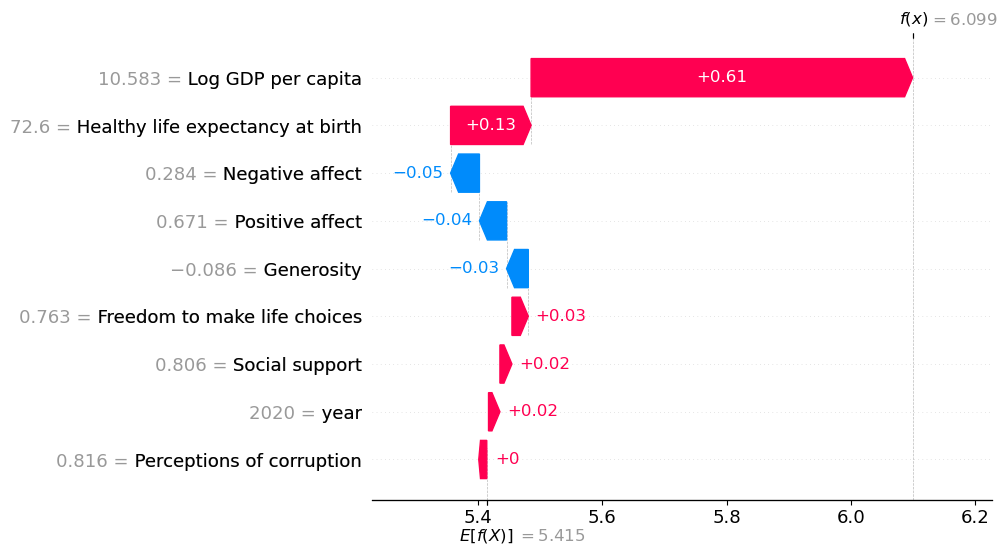

In [36]:
#Summarize the SHAP values for a specific prediction (year 2020) with lightgbm model
shap.plots.waterfall(shap_values_lgbm[100])

### Waterfall LightGBM Regressor shows how each feature contributes to the prediction for one sample. In above sample prediction for sample 100, log gdp per capita has more positive contribution than Perception of corruption. This sample also shows that freedom to make life choices, social support and year has very least contribution towards prediction. Wheras the negative affect , Postive affect and Generosity features are pulling the prediction down.

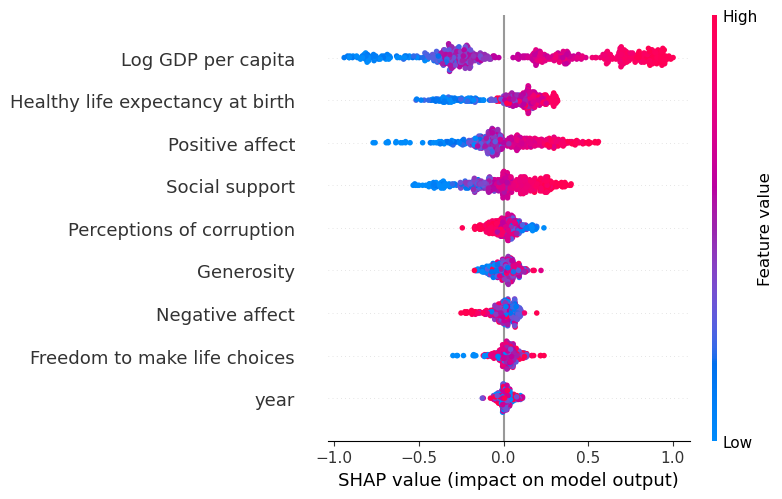

In [37]:
shap.summary_plot(shap_values_lgbm[:500], features_test[:500], show= False)

### Summary plot on LightGBM Regressor gives global overview of feature importance distribution for all samples in whole dataset. This shows the whole dataset.  It can be seen that Log GDP per capita has more data points distribution which is in red. It can be concluded that this feature is moving the prediction to the higher followed by Positive affect and Social support.

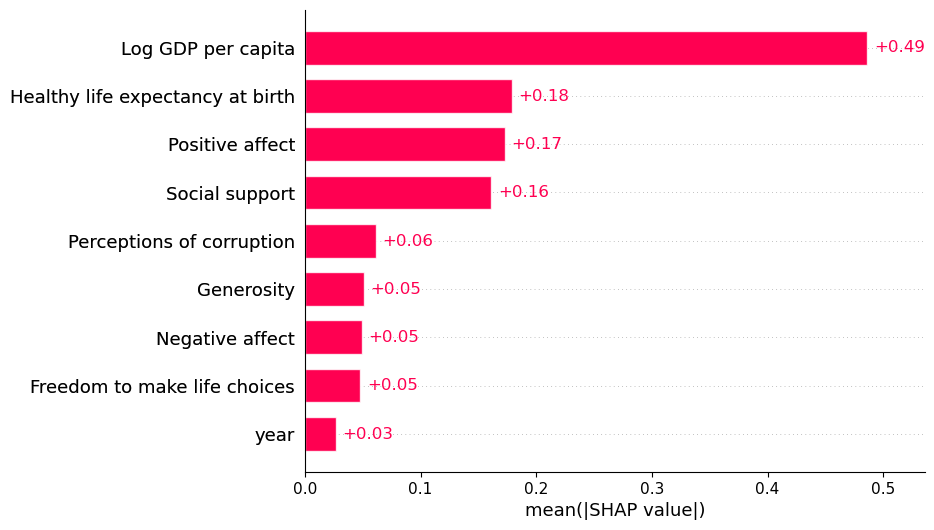

In [38]:
shap.plots.bar(shap_values_lgbm)

### Bar plot on LightGBM Regressor is showing the average absolute SHAP values for each features. Its helps to understand which features are most important in the overall dataset. LightGBM model gave more importance to Log GDP per capita feature by (+0.13) than Catboost model . But on the other hand Light GBM gave less importance to Healthy life expectancy at birth than Catboost model.

In [39]:

model2 = CatBoostRegressor(n_estimators= 190, max_depth= 8).fit(features_train, target_train)

explainer = shap.Explainer(model2, features_train)
shap_values_cbr = explainer(features_test, check_additivity=False)


Learning rate set to 0.172173
0:	learn: 0.9903169	total: 4.27ms	remaining: 806ms
1:	learn: 0.8790332	total: 8.09ms	remaining: 761ms
2:	learn: 0.7876228	total: 11.7ms	remaining: 731ms
3:	learn: 0.7154097	total: 15ms	remaining: 696ms
4:	learn: 0.6540750	total: 17.7ms	remaining: 656ms
5:	learn: 0.6068732	total: 21.7ms	remaining: 666ms
6:	learn: 0.5697233	total: 25.2ms	remaining: 660ms
7:	learn: 0.5352018	total: 28.1ms	remaining: 639ms
8:	learn: 0.5106410	total: 30.8ms	remaining: 619ms
9:	learn: 0.4911071	total: 34.3ms	remaining: 617ms
10:	learn: 0.4724149	total: 37.4ms	remaining: 608ms
11:	learn: 0.4561002	total: 40.6ms	remaining: 602ms
12:	learn: 0.4430904	total: 43.5ms	remaining: 592ms
13:	learn: 0.4333684	total: 46ms	remaining: 579ms
14:	learn: 0.4252867	total: 48.8ms	remaining: 569ms
15:	learn: 0.4165425	total: 51.9ms	remaining: 565ms
16:	learn: 0.4101592	total: 54.9ms	remaining: 558ms
17:	learn: 0.4037584	total: 57.7ms	remaining: 551ms
18:	learn: 0.3962134	total: 60.3ms	remaining: 54

### Waterfall CatBoost Regressor shows how each feature contributes to the prediction for one sample. In above sample prediction for sample 100, log gdp per capita has more positive contribution followed by healthy life expectancy at birth.This sample also shows that freedom to make life choices, and Perception of corruption has very least contribution towards prediction. Whereas the Year, Social support, Negative affect , Postive affect and Generosity features are pulling the prediction down.

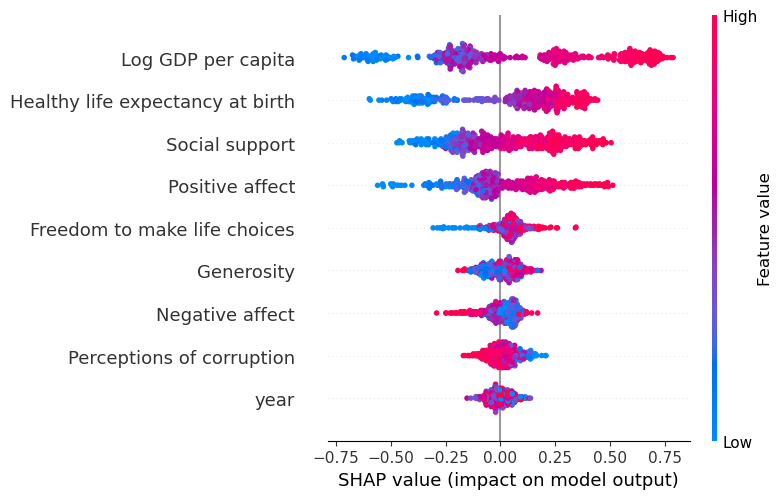

In [41]:
shap.summary_plot(shap_values_cbr[:500], features_test[:500], show= False)

In [ ]:
#Summarize the SHAP values for a specific prediction (year 2020) with catboost model
shap.plots.waterfall(shap_values_cbr[100])

### Summary plot on CatBoost Regressor gives global overview of feature importance distribution for all samples in whole dataset. It can be seen that Log GDP per capita has more red data point which are moving towards the positive class(happiness). It can be concluded that this feature is moving the prediction to the higher which means it is increasing the model output followed by Positive affect, Social support, Healthy life expectancy at birth.

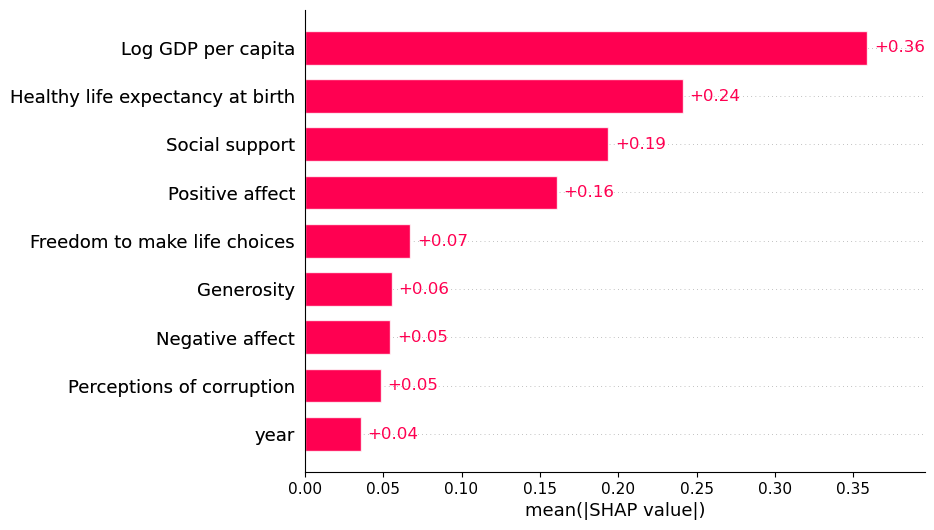

In [42]:
shap.plots.bar(shap_values_cbr)

 ### Bar plot on CatBoost Regressor is showing the average absolute SHAP values for each features in whole dataset.  Its helps to understand which features are most important in the overall dataset. Catboost model gave little bit less importance than Light GBM model to Log GDP per capita feature. But on the other hand Catboost gave more importance to Healthy life expectancy at birth (+0.24) which is more than LightGBM by (+0.6).

## Conclusion on Shap 
 - The social support in the specific sample which was pulled is from year 2020. It was the time when COVID pandemic so that can be the reason why it is pulling prediction down in catboost model(0.05). As thier were less friends and family support as people were cooped up in thier own houses and unable to be in office setting or social setting due to quarantine rules.

 - Even during 2020 the birth of healthy babies was increasing happiness score in families as we see positive effect on prediction. So it can be said that this feature did not get much affected in 2020 due to COVID. It could be because both parents were home supporting each other mentally and physically. Overall data set and specific prediction are almost same.

 -  Higher Log GDP increase happiness: As needs and wants are both taken care.

 It is also noticed that freedom to life choices has minimal positive effect(+0.05) that year on happiness score because the rules got more strict than other years.



## Conclusions:
- Higher Log GDP per capita increase happiness  because of factors below:
   - Basic Needs Fulfillment: Higher income allows people to afford food, shelter, healthcare, and education — all essential for well-being.
   - Security and Stability: Economic prosperity reduces stress related to survival and financial insecurity.
   - Access to Opportunities: Wealthier countries often provide better infrastructure, education, and job opportunities, which contribute to life satisfaction.
   - Public Services: Higher GDP per capita often correlates with better public services (e.g., clean water, transportation, safety), which improve quality of life.
   - Social Comparison: People compare themselves to others. In wealthier societies, higher income can improve perceived social status, which affects happiness.

- Healthy babies increases happiness in families.
    - 🌱 1. Better Quality of Life: People who live longer in good health can enjoy life more fully. They’re more likely to engage in social, recreational, and meaningful activities.
    - 🧠 2. Reduced Stress and Anxiety: Knowing you’re likely to live a long, healthy life reduces fear of illness and death. It also lowers financial stress related to healthcare costs and dependency.
    - 👨‍👩‍👧‍👦 3. Stronger Social Bonds: Healthy individuals can maintain relationships longer, care for loved ones, and participate in community life. This boosts emotional   well-being and social support — key drivers of happiness.
    - 💼 4. Economic Productivity: Healthy populations are more productive, which improves national prosperity.This can lead to better infrastructure, education, and public services — all linked to happiness.
    - 🏥 5. Confidence in Healthcare Systems: High healthy life expectancy often reflects strong healthcare systems.People feel more secure and optimistic when they trust their health system.

- Generosity in this dataset was not majorily impacting happiness(0.18 correlation)

 ### Recommendations
 
  - Further improvements can be considering by adding more features for deciding happiness like climate  of the country, government spending.
  - Greater attention should be directed toward less happy countries so that governments can identify the underlying causes and implement strategies to improve overall   well-being.
